[INFO] Processing cohort '6555_Lung_carcinoma': 59 sample(s) found.
[INFO] Processing cohort '6712_Oral_SCC': 53 sample(s) found.
[INFO] Processing cohort '6841_Meningioma': 32 sample(s) found.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 30 sample(s) found.
[INFO] Processing cohort '6982_Lymphoma': 56 sample(s) found.
[INFO] Processing cohort '7040_BCC': 40 sample(s) found.
[INFO] Processing cohort '7098_Glioma': 8 sample(s) found.
[INFO] Processing cohort '6711_Cutaneous_SCC': 62 sample(s) found.
[INFO] Processing cohort '6713_Cutaneous_MCT': 44 sample(s) found.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 34 sample(s) found.
[INFO] Processing cohort '6973_OSA': 29 sample(s) found.
[INFO] Processing cohort '6990_Mammary_carcinoma': 52 sample(s) found.
[INFO] Processing cohort '7097_CRC': 34 sample(s) found.


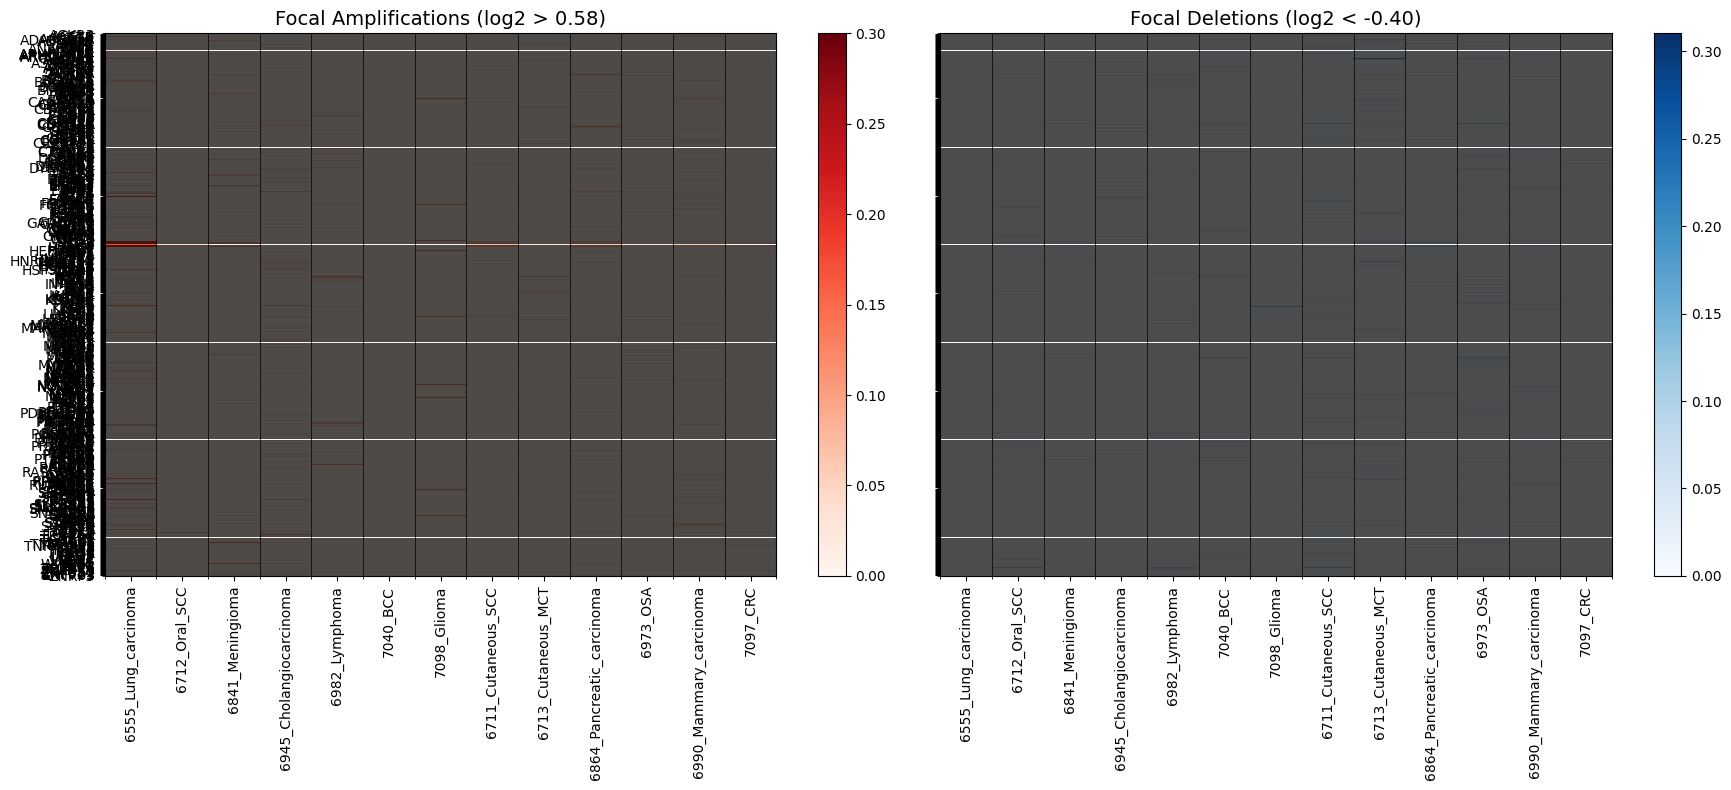

In [23]:
#!/usr/bin/env python3
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 1_000_000      # Only segments < 1 Mb considered focal
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Frequency filter: only keep genes with max frequency >= this threshold
MIN_FREQ_THRESHOLD = 0.01  # 10%

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}
del_counts = {}
total_samples = {}

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    total_samples[cohort] = len(seg_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(seg_files)} sample(s) found.")
    
    for seg_file in seg_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]
        
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes = set()
        sample_del_genes = set()
        
        # Process amplification calls
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)
        
        # Process deletion calls
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)
        
        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

# ---------------------------
# FILTER GENES BY MINIMUM FREQUENCY
# ---------------------------
# Add a temporary column with the maximum frequency per gene.
amp_freq_df["max_freq"] = amp_freq_df.max(axis=1)
filtered_amp_freq_df = amp_freq_df[amp_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")

del_freq_df["max_freq"] = del_freq_df.max(axis=1)
filtered_del_freq_df = del_freq_df[del_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")

# Combine genes from both calls.
combined_genes = set(filtered_amp_freq_df.index) | set(filtered_del_freq_df.index)
combined_genes_list = sorted(combined_genes)  # Sorted list for consistency

# Reindex both DataFrames so that missing genes are filled with 0.
filtered_amp_freq_df = amp_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")
filtered_del_freq_df = del_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")

# Use the filtered DataFrames for plotting.
amp_freq_df = filtered_amp_freq_df
del_freq_df = filtered_del_freq_df

# ---------------------------
# CREATE HEATMAPS WITH SHADING AND GRIDLINES
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# --- Amplifications Heatmap ---
im_amp = axes[0].imshow(amp_freq_df.values, cmap="Reds", aspect="auto", interpolation="nearest")
axes[0].set_xticks(np.arange(len(amp_freq_df.columns)))
axes[0].set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
axes[0].set_yticks(np.arange(len(amp_freq_df.index)))
axes[0].set_yticklabels(amp_freq_df.index, fontsize=10)
axes[0].set_title(f"Focal Amplifications (log2 > {GAIN_THRESHOLD:.2f})", fontsize=14)

# Set minor ticks for gridlines.
axes[0].set_xticks(np.arange(-0.5, len(amp_freq_df.columns), 1), minor=True)
axes[0].set_yticks(np.arange(-0.5, len(amp_freq_df.index), 1), minor=True)
axes[0].grid(which="minor", color="black", linestyle='-', linewidth=0.5)
plt.colorbar(im_amp, ax=axes[0])

# --- Deletions Heatmap ---
im_del = axes[1].imshow(del_freq_df.values, cmap="Blues", aspect="auto", interpolation="nearest")
axes[1].set_xticks(np.arange(len(del_freq_df.columns)))
axes[1].set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
axes[1].set_yticks(np.arange(len(del_freq_df.index)))
axes[1].set_yticklabels(del_freq_df.index, fontsize=10)
axes[1].set_title(f"Focal Deletions (log2 < {LOSS_THRESHOLD:.2f})", fontsize=14)

axes[1].set_xticks(np.arange(-0.5, len(del_freq_df.columns), 1), minor=True)
axes[1].set_yticks(np.arange(-0.5, len(del_freq_df.index), 1), minor=True)
axes[1].grid(which="minor", color="black", linestyle='-', linewidth=0.5)
plt.colorbar(im_del, ax=axes[1])

plt.tight_layout()
plt.savefig("focal_amp_del_heatmap_min_freq.png", dpi=300)
plt.show()


[INFO] Processing cohort '6555_Lung_carcinoma': 59 sample(s) found.
[INFO] Processing cohort '6712_Oral_SCC': 53 sample(s) found.
[INFO] Processing cohort '6841_Meningioma': 32 sample(s) found.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 30 sample(s) found.
[INFO] Processing cohort '6982_Lymphoma': 56 sample(s) found.
[INFO] Processing cohort '7040_BCC': 40 sample(s) found.
[INFO] Processing cohort '7098_Glioma': 8 sample(s) found.
[INFO] Processing cohort '6711_Cutaneous_SCC': 62 sample(s) found.
[INFO] Processing cohort '6713_Cutaneous_MCT': 44 sample(s) found.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 34 sample(s) found.
[INFO] Processing cohort '6973_OSA': 29 sample(s) found.
[INFO] Processing cohort '6990_Mammary_carcinoma': 52 sample(s) found.
[INFO] Processing cohort '7097_CRC': 34 sample(s) found.


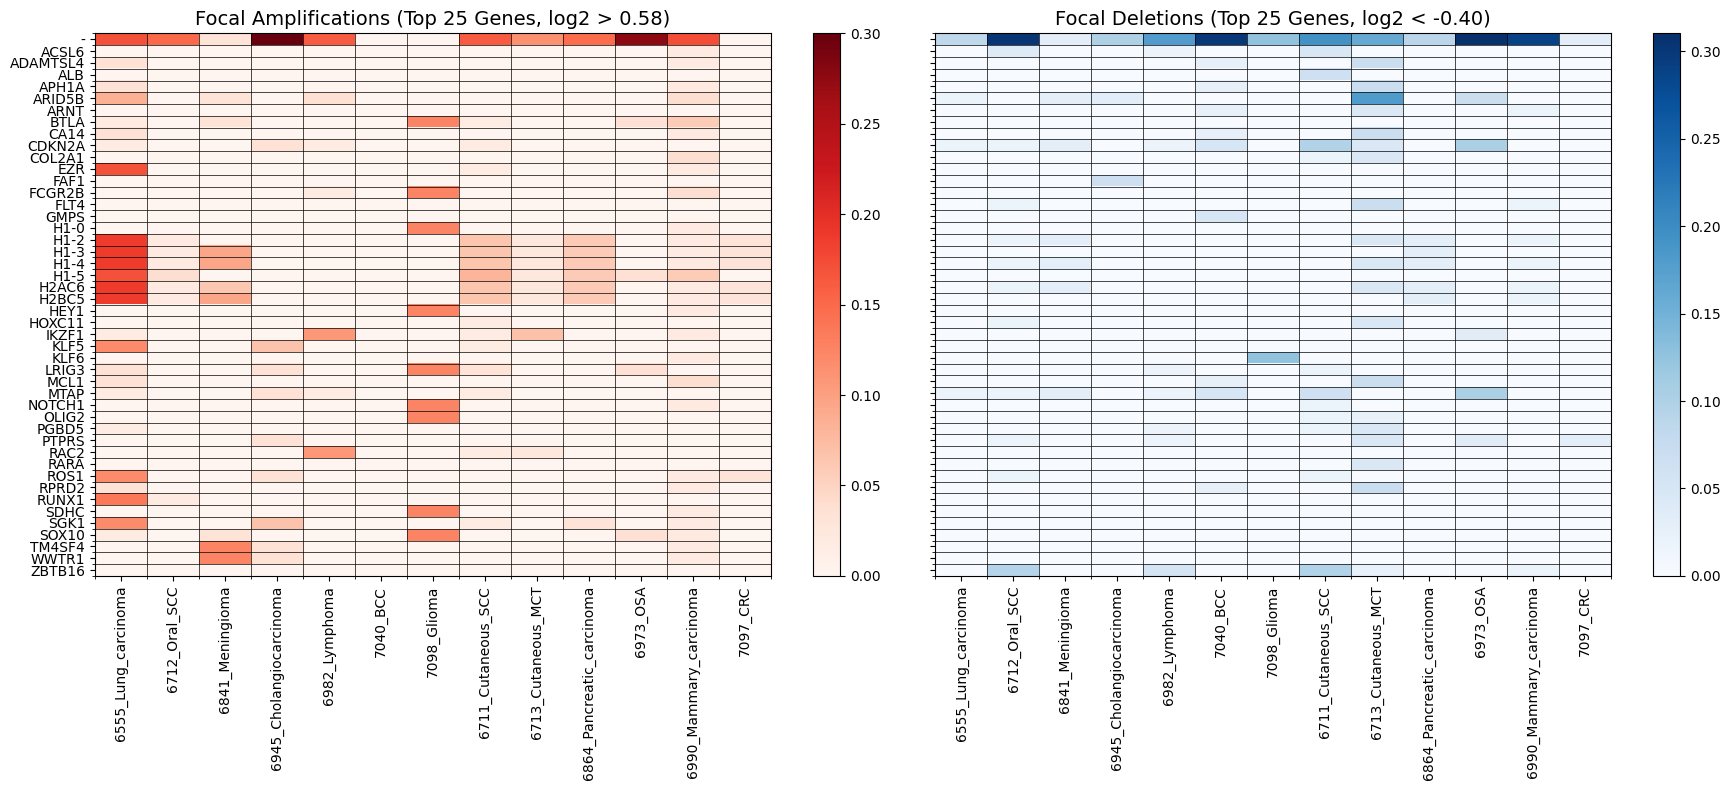

In [21]:
#!/usr/bin/env python3
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 1_000_000
GAIN_THRESHOLD = 0.585
LOSS_THRESHOLD = -0.4
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Number of top genes to keep for each alteration type
TOP_N = 25

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}
del_counts = {}
total_samples = {}

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    total_samples[cohort] = len(seg_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(seg_files)} sample(s) found.")
    
    for seg_file in seg_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]
        
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes = set()
        sample_del_genes = set()
        
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)
        
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)
        
        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

# ---------------------------
# KEEP ONLY THE TOP N GENES
# ---------------------------
# Add temporary column for max frequency.
amp_freq_df["max_freq"] = amp_freq_df.max(axis=1)
top_amp_genes = amp_freq_df["max_freq"].sort_values(ascending=False).head(TOP_N).index
filtered_amp_freq_df = amp_freq_df.loc[top_amp_genes].drop(columns="max_freq")

del_freq_df["max_freq"] = del_freq_df.max(axis=1)
top_del_genes = del_freq_df["max_freq"].sort_values(ascending=False).head(TOP_N).index
filtered_del_freq_df = del_freq_df.loc[top_del_genes].drop(columns="max_freq")

# Combine the gene sets from both calls.
combined_genes = set(top_amp_genes) | set(top_del_genes)
combined_genes_list = sorted(combined_genes)

# Reindex both DataFrames to ensure all genes appear.
filtered_amp_freq_df = amp_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")
filtered_del_freq_df = del_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")

amp_freq_df = filtered_amp_freq_df
del_freq_df = filtered_del_freq_df

# ---------------------------
# CREATE HEATMAPS WITH SHADING AND GRIDLINES
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# --- Amplifications Heatmap ---
im_amp = axes[0].imshow(amp_freq_df.values, cmap="Reds", aspect="auto", interpolation="nearest")
axes[0].set_xticks(np.arange(len(amp_freq_df.columns)))
axes[0].set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
axes[0].set_yticks(np.arange(len(amp_freq_df.index)))
axes[0].set_yticklabels(amp_freq_df.index, fontsize=10)
axes[0].set_title(f"Focal Amplifications (Top {TOP_N} Genes, log2 > {GAIN_THRESHOLD:.2f})", fontsize=14)
axes[0].set_xticks(np.arange(-0.5, len(amp_freq_df.columns), 1), minor=True)
axes[0].set_yticks(np.arange(-0.5, len(amp_freq_df.index), 1), minor=True)
axes[0].grid(which="minor", color="black", linestyle='-', linewidth=0.5)
plt.colorbar(im_amp, ax=axes[0])

# --- Deletions Heatmap ---
im_del = axes[1].imshow(del_freq_df.values, cmap="Blues", aspect="auto", interpolation="nearest")
axes[1].set_xticks(np.arange(len(del_freq_df.columns)))
axes[1].set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
axes[1].set_yticks(np.arange(len(del_freq_df.index)))
axes[1].set_yticklabels(del_freq_df.index, fontsize=10)
axes[1].set_title(f"Focal Deletions (Top {TOP_N} Genes, log2 < {LOSS_THRESHOLD:.2f})", fontsize=14)
axes[1].set_xticks(np.arange(-0.5, len(del_freq_df.columns), 1), minor=True)
axes[1].set_yticks(np.arange(-0.5, len(del_freq_df.index), 1), minor=True)
axes[1].grid(which="minor", color="black", linestyle='-', linewidth=0.5)
plt.colorbar(im_del, ax=axes[1])

plt.tight_layout()
plt.savefig("focal_amp_del_heatmap_topN.png", dpi=300)
plt.show()


[INFO] Processing cohort '6555_Lung_carcinoma': 59 sample(s) found.
[INFO] Processing cohort '6712_Oral_SCC': 53 sample(s) found.
[INFO] Processing cohort '6841_Meningioma': 32 sample(s) found.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 30 sample(s) found.
[INFO] Processing cohort '6982_Lymphoma': 56 sample(s) found.
[INFO] Processing cohort '7040_BCC': 40 sample(s) found.
[INFO] Processing cohort '7098_Glioma': 8 sample(s) found.
[INFO] Processing cohort '6711_Cutaneous_SCC': 62 sample(s) found.
[INFO] Processing cohort '6713_Cutaneous_MCT': 44 sample(s) found.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 34 sample(s) found.
[INFO] Processing cohort '6973_OSA': 29 sample(s) found.
[INFO] Processing cohort '6990_Mammary_carcinoma': 52 sample(s) found.
[INFO] Processing cohort '7097_CRC': 34 sample(s) found.


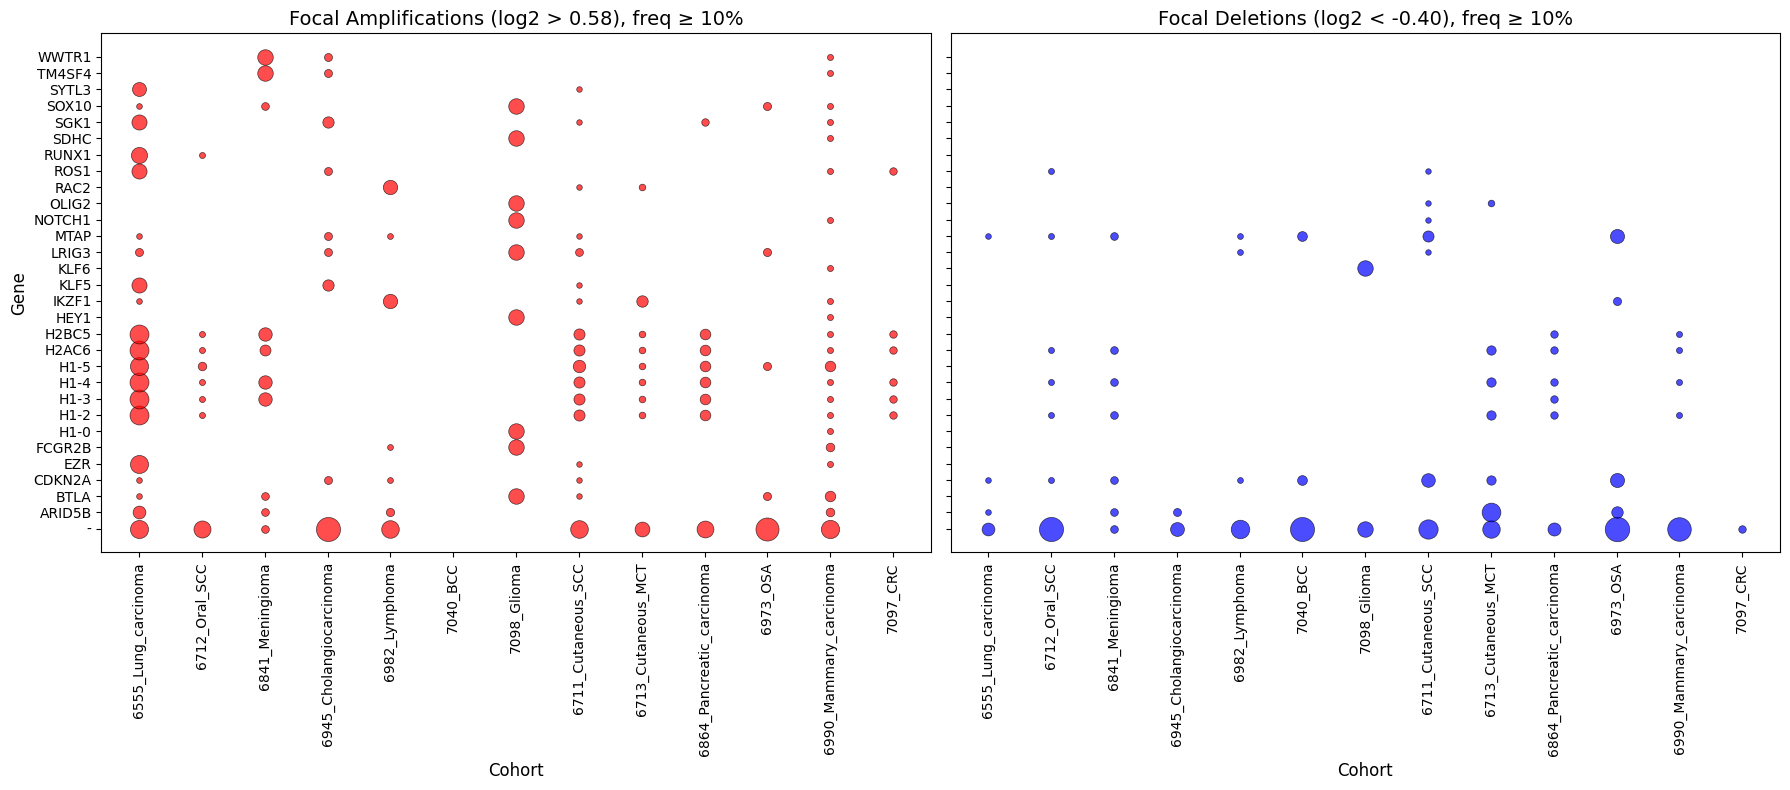

In [22]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 1_000_000      # Only segments < 1 Mb considered focal
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Frequency filter: only keep genes with max frequency >= this threshold
MIN_FREQ_THRESHOLD = 0.10  # 10%

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}
del_counts = {}
total_samples = {}

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))

    total_samples[cohort] = len(seg_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(seg_files)} sample(s) found.")

    for seg_file in seg_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue

        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]

        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]

        sample_amp_genes = set()
        sample_del_genes = set()

        # Collect unique amplified genes
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)

        # Collect unique deleted genes
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)

        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

# ---------------------------
# FILTER GENES BY MINIMUM FREQUENCY
# ---------------------------
# Add a temporary column to record the maximum frequency per gene.
amp_freq_df["max_freq"] = amp_freq_df.max(axis=1)
filtered_amp_freq_df = amp_freq_df[amp_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")

del_freq_df["max_freq"] = del_freq_df.max(axis=1)
filtered_del_freq_df = del_freq_df[del_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")

# (Optional) Use the union of genes that pass the threshold in either amplifications or deletions.
combined_genes = set(filtered_amp_freq_df.index) | set(filtered_del_freq_df.index)
combined_genes_list = sorted(combined_genes)  # Convert set to sorted list for indexing

# Instead of .loc[], use reindex to include any genes missing in one DataFrame.
filtered_amp_freq_df = amp_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")
filtered_del_freq_df = del_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")

# Replace the original dataframes with the filtered versions for plotting.
amp_freq_df = filtered_amp_freq_df
del_freq_df = filtered_del_freq_df

# ---------------------------
# CREATE BUBBLE PLOTS
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
size_scale = 1000

# Plot Amplifications
ax_amp = axes[0]
for i, gene in enumerate(amp_freq_df.index):
    for j, cohort in enumerate(amp_freq_df.columns):
        freq = amp_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_amp.set_xticks(list(range(len(amp_freq_df.columns))))
ax_amp.set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
ax_amp.set_yticks(list(range(len(amp_freq_df.index))))
ax_amp.set_yticklabels(amp_freq_df.index, fontsize=10)
ax_amp.set_xlabel("Cohort", fontsize=12)
ax_amp.set_ylabel("Gene", fontsize=12)
ax_amp.set_title(f"Focal Amplifications (log2 > {GAIN_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD:.0%}", fontsize=14)

# Plot Deletions
ax_del = axes[1]
for i, gene in enumerate(del_freq_df.index):
    for j, cohort in enumerate(del_freq_df.columns):
        freq = del_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_del.set_xticks(list(range(len(del_freq_df.columns))))
ax_del.set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
ax_del.set_yticks(list(range(len(del_freq_df.index))))
ax_del.set_yticklabels(del_freq_df.index, fontsize=10)
ax_del.set_xlabel("Cohort", fontsize=12)
ax_del.set_title(f"Focal Deletions (log2 < {LOSS_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD:.0%}", fontsize=14)

plt.tight_layout()
plt.savefig("focal_amp_del_bubble_plots_min_freq.png", dpi=300)
plt.show()


[INFO] Processing cohort '6555_Lung_carcinoma': 59 sample(s) found.
[INFO] Processing cohort '6712_Oral_SCC': 53 sample(s) found.
[INFO] Processing cohort '6841_Meningioma': 32 sample(s) found.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 30 sample(s) found.
[INFO] Processing cohort '6982_Lymphoma': 56 sample(s) found.
[INFO] Processing cohort '7040_BCC': 40 sample(s) found.
[INFO] Processing cohort '7098_Glioma': 8 sample(s) found.
[INFO] Processing cohort '6711_Cutaneous_SCC': 62 sample(s) found.
[INFO] Processing cohort '6713_Cutaneous_MCT': 44 sample(s) found.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 34 sample(s) found.
[INFO] Processing cohort '6973_OSA': 29 sample(s) found.
[INFO] Processing cohort '6990_Mammary_carcinoma': 52 sample(s) found.
[INFO] Processing cohort '7097_CRC': 34 sample(s) found.


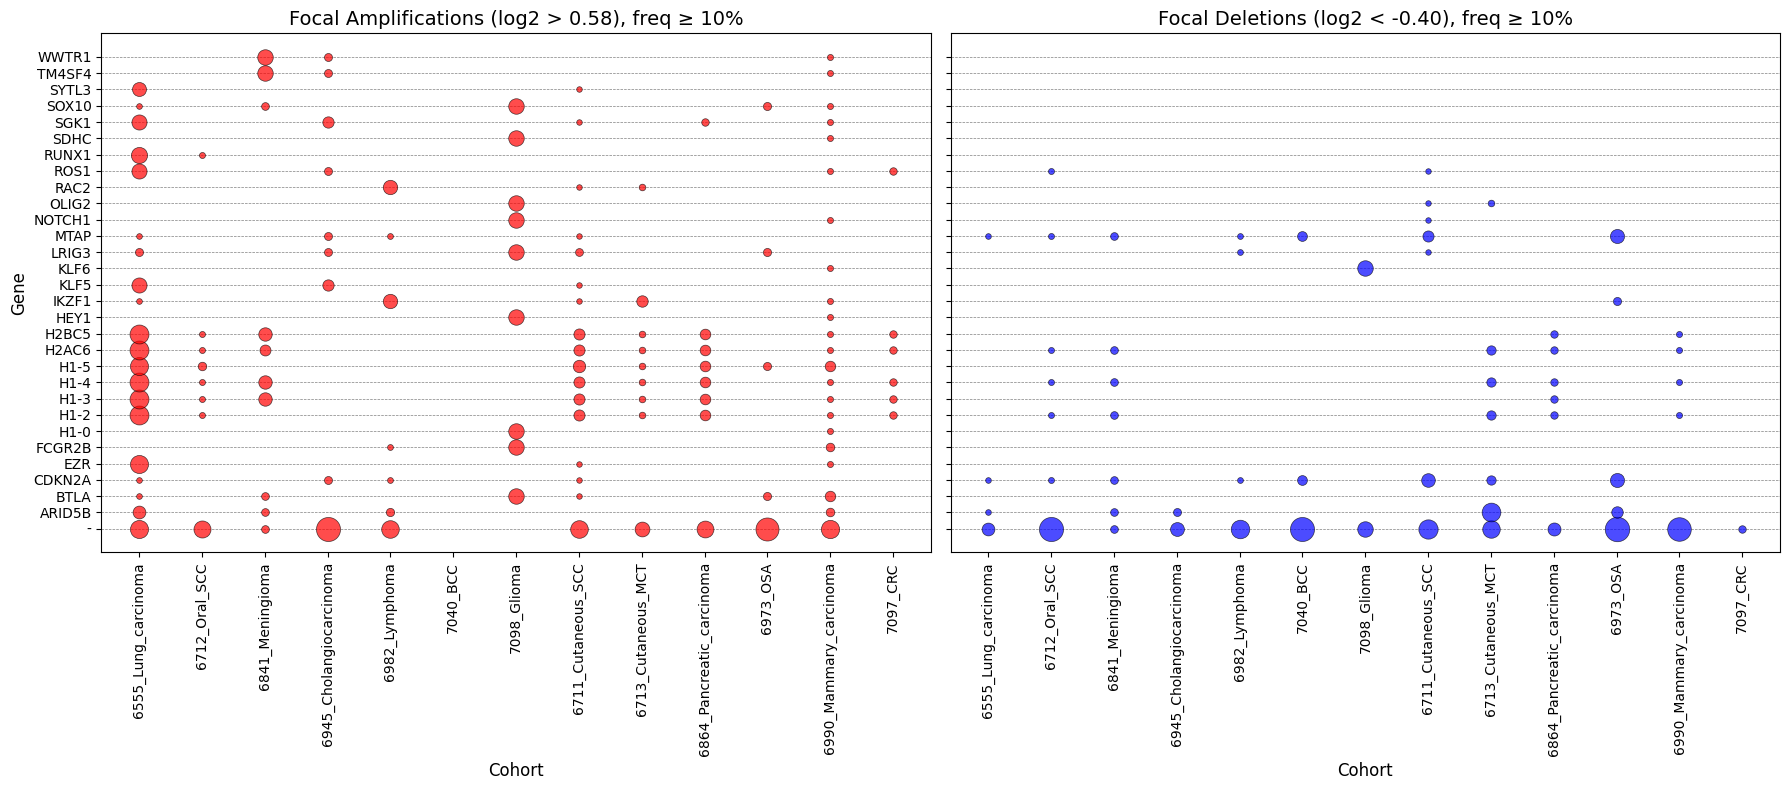

In [24]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 1_000_000      # Only segments < 1 Mb considered focal
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Frequency filter: only keep genes with max frequency >= this threshold
MIN_FREQ_THRESHOLD = 0.10  # 10%

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}
del_counts = {}
total_samples = {}

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))

    total_samples[cohort] = len(seg_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(seg_files)} sample(s) found.")

    for seg_file in seg_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue

        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]

        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]

        sample_amp_genes = set()
        sample_del_genes = set()

        # Collect unique amplified genes
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)

        # Collect unique deleted genes
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)

        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

# ---------------------------
# FILTER GENES BY MINIMUM FREQUENCY
# ---------------------------
# Add a temporary column to record the maximum frequency per gene.
amp_freq_df["max_freq"] = amp_freq_df.max(axis=1)
filtered_amp_freq_df = amp_freq_df[amp_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")

del_freq_df["max_freq"] = del_freq_df.max(axis=1)
filtered_del_freq_df = del_freq_df[del_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")

# (Optional) Use the union of genes that pass the threshold in either amplifications or deletions.
combined_genes = set(filtered_amp_freq_df.index) | set(filtered_del_freq_df.index)
combined_genes_list = sorted(combined_genes)  # Convert set to sorted list for indexing

# Instead of .loc[], use reindex to include any genes missing in one DataFrame.
filtered_amp_freq_df = amp_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")
filtered_del_freq_df = del_freq_df.reindex(combined_genes_list, fill_value=0).drop(columns="max_freq", errors="ignore")

# Replace the original dataframes with the filtered versions for plotting.
amp_freq_df = filtered_amp_freq_df
del_freq_df = filtered_del_freq_df

# ---------------------------
# CREATE BUBBLE PLOTS
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
size_scale = 1000

# Plot Amplifications
ax_amp = axes[0]
for i, gene in enumerate(amp_freq_df.index):
    for j, cohort in enumerate(amp_freq_df.columns):
        freq = amp_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                           edgecolors='k', linewidth=0.5)

ax_amp.set_xticks(list(range(len(amp_freq_df.columns))))
ax_amp.set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
ax_amp.set_yticks(list(range(len(amp_freq_df.index))))
ax_amp.set_yticklabels(amp_freq_df.index, fontsize=10)
ax_amp.set_xlabel("Cohort", fontsize=12)
ax_amp.set_ylabel("Gene", fontsize=12)
ax_amp.set_title(f"Focal Amplifications (log2 > {GAIN_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD:.0%}", fontsize=14)

# Add horizontal grid lines
ax_amp.set_axisbelow(True)
ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Plot Deletions
ax_del = axes[1]
for i, gene in enumerate(del_freq_df.index):
    for j, cohort in enumerate(del_freq_df.columns):
        freq = del_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                           edgecolors='k', linewidth=0.5)

ax_del.set_xticks(list(range(len(del_freq_df.columns))))
ax_del.set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
ax_del.set_yticks(list(range(len(del_freq_df.index))))
ax_del.set_yticklabels(del_freq_df.index, fontsize=10)
ax_del.set_xlabel("Cohort", fontsize=12)
ax_del.set_title(f"Focal Deletions (log2 < {LOSS_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD:.0%}", fontsize=14)

# Add horizontal grid lines
ax_del.set_axisbelow(True)
ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("focal_amp_del_bubble_plots_min_freq.png", dpi=300)
plt.show()


[INFO] Processing cohort '6555_Lung_carcinoma': 59 sample(s) found.
[INFO] Processing cohort '6712_Oral_SCC': 53 sample(s) found.
[INFO] Processing cohort '6841_Meningioma': 32 sample(s) found.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 30 sample(s) found.
[INFO] Processing cohort '6982_Lymphoma': 56 sample(s) found.
[INFO] Processing cohort '7040_BCC': 40 sample(s) found.
[INFO] Processing cohort '7098_Glioma': 8 sample(s) found.
[INFO] Processing cohort '6711_Cutaneous_SCC': 62 sample(s) found.
[INFO] Processing cohort '6713_Cutaneous_MCT': 44 sample(s) found.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 34 sample(s) found.
[INFO] Processing cohort '6973_OSA': 29 sample(s) found.
[INFO] Processing cohort '6990_Mammary_carcinoma': 52 sample(s) found.
[INFO] Processing cohort '7097_CRC': 34 sample(s) found.


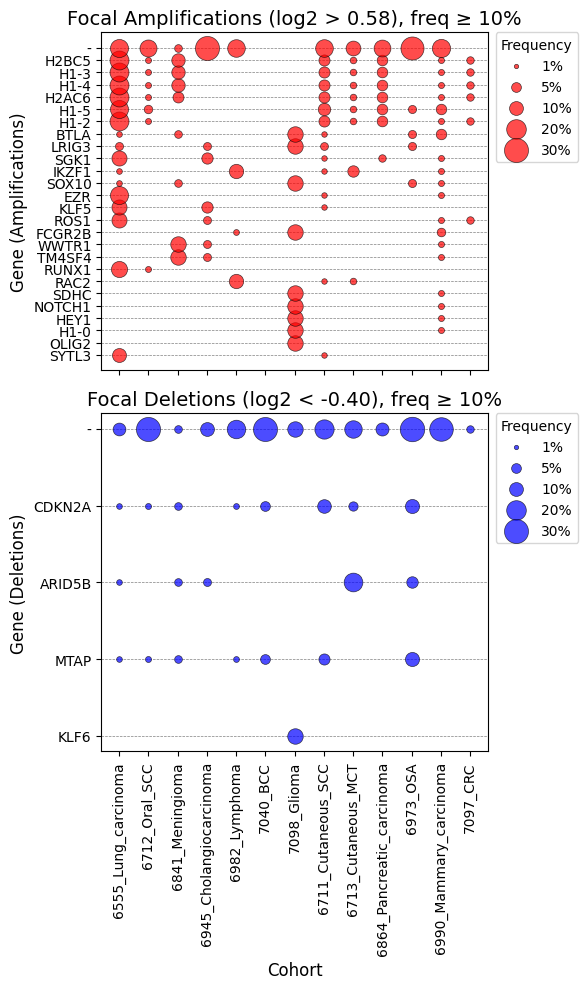

In [41]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 1_000_000      # Only segments < 1 Mb considered focal
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Frequency filter: only keep genes with max frequency >= this threshold
MIN_FREQ_THRESHOLD = 0.10  # 10%

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}
del_counts = {}
total_samples = {}

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))

    total_samples[cohort] = len(seg_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(seg_files)} sample(s) found.")

    for seg_file in seg_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue

        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]

        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]

        sample_amp_genes = set()
        sample_del_genes = set()

        # Collect unique amplified genes
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)

        # Collect unique deleted genes
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)

        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

# ---------------------------
# FILTER GENES SEPARATELY FOR GAINS AND LOSSES
# ---------------------------
# For Amplifications: keep only genes with max frequency >= threshold.
amp_freq_df["max_freq"] = amp_freq_df.max(axis=1)
filtered_amp_freq_df = amp_freq_df[amp_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")
# Sort amplification genes by average frequency across cohorts (descending)
filtered_amp_freq_df = filtered_amp_freq_df.assign(avg_freq=filtered_amp_freq_df.mean(axis=1))\
                                           .sort_values("avg_freq", ascending=True)\
                                           .drop(columns="avg_freq")

# For Deletions: keep only genes with max frequency >= threshold.
del_freq_df["max_freq"] = del_freq_df.max(axis=1)
filtered_del_freq_df = del_freq_df[del_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD].drop(columns="max_freq")
# Sort deletion genes by average frequency (descending)
filtered_del_freq_df = filtered_del_freq_df.assign(avg_freq=filtered_del_freq_df.mean(axis=1))\
                                           .sort_values("avg_freq", ascending=True)\
                                           .drop(columns="avg_freq")

# Use the filtered DataFrames separately.
amp_freq_df = filtered_amp_freq_df
del_freq_df = filtered_del_freq_df

# ---------------------------
# CREATE STACKED BUBBLE PLOTS (Shared X-Axis)
# Each plot uses its own ordered gene list
# ---------------------------
fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 10), sharex=True)
size_scale = 1000

# --- Amplifications (Top Plot) ---
for i, gene in enumerate(amp_freq_df.index):
    for j, cohort in enumerate(amp_freq_df.columns):
        freq = amp_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                             edgecolors='k', linewidth=0.5)
ax_amp.set_title(f"Focal Amplifications (log2 > {GAIN_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD:.0%}",
                 fontsize=14)
ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12)
ax_amp.set_yticks(range(len(amp_freq_df.index)))
ax_amp.set_yticklabels(amp_freq_df.index, fontsize=10)
ax_amp.set_xticks(range(len(amp_freq_df.columns)))
ax_amp.set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
ax_amp.set_axisbelow(True)
ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Add a legend for amplification bubbles outside the plot area.
legend_sizes_amp = [0.01, 0.05, 0.10, 0.20, 0.30]  # example frequency values
legend_handles_amp = [plt.scatter([], [], s=f*size_scale, color='red', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_amp]
legend_labels_amp = [f"{f:.0%}" for f in legend_sizes_amp]
ax_amp.legend(legend_handles_amp, legend_labels_amp, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

# --- Deletions (Bottom Plot) ---
for i, gene in enumerate(del_freq_df.index):
    for j, cohort in enumerate(del_freq_df.columns):
        freq = del_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                             edgecolors='k', linewidth=0.5)
ax_del.set_title(f"Focal Deletions (log2 < {LOSS_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD:.0%}",
                 fontsize=14)
ax_del.set_ylabel("Gene (Deletions)", fontsize=12)
ax_del.set_xlabel("Cohort", fontsize=12)
ax_del.set_yticks(range(len(del_freq_df.index)))
ax_del.set_yticklabels(del_freq_df.index, fontsize=10)
ax_del.set_xticks(range(len(del_freq_df.columns)))
ax_del.set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
ax_del.set_axisbelow(True)
ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Add a legend for deletion bubbles outside the plot area.
legend_sizes_del = [0.01, 0.05, 0.10, 0.20, 0.30]
legend_handles_del = [plt.scatter([], [], s=f*size_scale, color='blue', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_del]
legend_labels_del = [f"{f:.0%}" for f in legend_sizes_del]
ax_del.legend(legend_handles_del, legend_labels_del, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.savefig("focal_amp_del_bubble_plots_min_freq_stacked_ordered.png", dpi=300)
plt.show()


[INFO] Loaded 66 sample IDs to exclude.
[INFO] Loaded 51 unnamed gene entries from BED file.
[INFO] Processing cohort '6555_Lung_carcinoma': 55 sample(s) after exclusion.
[INFO] Processing cohort '6712_Oral_SCC': 36 sample(s) after exclusion.
[INFO] Processing cohort '6841_Meningioma': 28 sample(s) after exclusion.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 29 sample(s) after exclusion.
[INFO] Processing cohort '6982_Lymphoma': 50 sample(s) after exclusion.
[INFO] Processing cohort '7040_BCC': 39 sample(s) after exclusion.
[INFO] Processing cohort '7098_Glioma': 7 sample(s) after exclusion.
[INFO] Processing cohort '6711_Cutaneous_SCC': 57 sample(s) after exclusion.
[INFO] Processing cohort '6713_Cutaneous_MCT': 36 sample(s) after exclusion.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 27 sample(s) after exclusion.
[INFO] Processing cohort '6973_OSA': 25 sample(s) after exclusion.
[INFO] Processing cohort '6990_Mammary_carcinoma': 46 sample(s) after exclusion.
[INFO] 

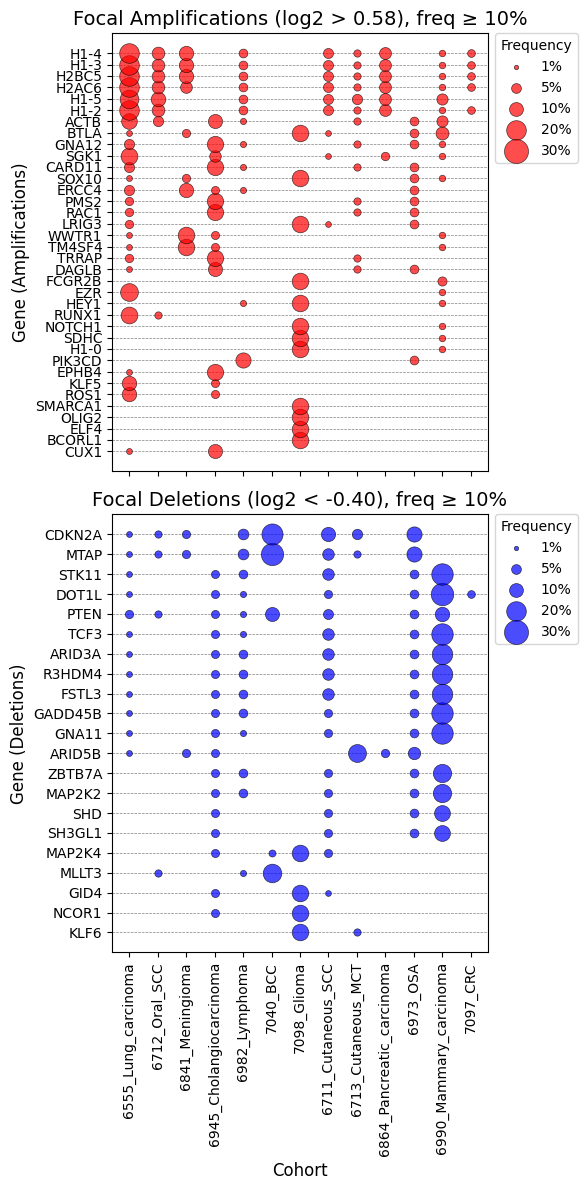

In [23]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 10_000_000      # Only segments < 1 Mb are considered focal.
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585.
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4.
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Frequency filters: separate thresholds for gains and losses.
MIN_FREQ_THRESHOLD_GAIN = 0.10  # e.g., 10% for gains.
MIN_FREQ_THRESHOLD_LOSS = 0.10   # e.g., 5% for losses.

# Provide the path to the BED file for unnamed genes.
# The BED file is expected to have no header and five columns:
# col0: dummy (always "-"), col1: Ensembl gene ID, col2: chromosome,
# col3: start coordinate, col4: end coordinate.
UNNAMED_GENES_BED_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/unnamed_genes.bed"  # <-- Update as needed

# Provide the path to the exclude file.
# This file contains sample IDs (one per line) to be excluded.
EXCLUDE_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/fur_cat.mad_filtering.samples_to_remove.txt"  # <-- Update as needed

# ---------------------------
# LOAD EXCLUDE FILE
# ---------------------------
exclude_set = set()
if os.path.exists(EXCLUDE_FILE):
    with open(EXCLUDE_FILE, 'r') as f:
        for line in f:
            sample_id = line.strip()
            if sample_id:
                exclude_set.add(sample_id)
    print(f"[INFO] Loaded {len(exclude_set)} sample IDs to exclude.")
else:
    print("[INFO] No exclude file provided or file not found.")

# ---------------------------
# HELPER FUNCTION: Replace Unnamed Gene Tokens with All Matches
# ---------------------------
def replace_gene_names_strict(gene_field, seg_chrom, seg_start, seg_end, bed_df):
    """
    Given a gene_field (a comma-separated string of gene tokens),
    if any token is "-", replace it by finding ALL BED rows for which the
    BED interval is fully contained within the focal segment (i.e. seg_start <= bed_start and seg_end >= bed_end)
    and the chromosome matches. All matching Ensembl gene IDs will be included.
    If no match is found, the "-" token is dropped.
    """
    tokens = [token.strip() for token in gene_field.split(",")]
    new_tokens = []
    for token in tokens:
        if token != "-":
            new_tokens.append(token)
        else:
            # For a "-" token, iterate over all rows in bed_df and add all matches.
            for _, bed_row in bed_df.iterrows():
                bed_chrom = str(bed_row["chrom"])
                try:
                    bed_start = int(bed_row["bed_start"])
                    bed_end   = int(bed_row["bed_end"])
                except Exception:
                    continue
                # Strict containment check: BED interval must be fully contained within the focal segment.
                if seg_chrom == bed_chrom and seg_start <= bed_start and seg_end >= bed_end:
                    new_tokens.append(bed_row["ensembl"])
            # Do not re-append "-" if no match is found.
    new_tokens = sorted(set(new_tokens))
    return ",".join(new_tokens)

# ---------------------------
# LOAD BED FILE FOR UNNAMED GENES (if provided)
# ---------------------------
bed_df = None
if os.path.exists(UNNAMED_GENES_BED_FILE):
    bed_df = pd.read_csv(UNNAMED_GENES_BED_FILE, sep="\t", header=None)
    bed_df.columns = ["dummy", "ensembl", "chrom", "bed_start", "bed_end"]
    print(f"[INFO] Loaded {len(bed_df)} unnamed gene entries from BED file.")
else:
    print("[INFO] No BED file for unnamed genes provided or file not found.")

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}    # To store counts of amplifications (gains) per gene per cohort.
del_counts = {}    # To store counts of deletions (losses) per gene per cohort.
total_samples = {} # To store number of samples per cohort.

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    # Exclude samples based on the exclude file.
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples[cohort] = len(non_excluded_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        # If a BED file is provided, update the "gene" column using strict containment logic.
        if bed_df is not None:
            # Assumes the segmentation file has a "chromosome" column.
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]
        
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes = set()
        sample_del_genes = set()
        
        # Process amplification calls.
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)
        
        # Process deletion calls.
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)
        
        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

# ---------------------------
# REMOVE ANY LEFTOVER "-" ROWS (just in case)
# ---------------------------
if "-" in amp_freq_df.index:
    amp_freq_df = amp_freq_df.drop("-", axis=0)
if "-" in del_freq_df.index:
    del_freq_df = del_freq_df.drop("-", axis=0)

# ---------------------------
# FILTER & ORDER GENES SEPARATELY FOR GAINS & LOSSES
# ---------------------------
# For Amplifications (Gains)
amp_freq_df["max_freq"] = amp_freq_df.max(axis=1)
filtered_amp_freq_df = amp_freq_df[amp_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD_GAIN].drop(columns="max_freq")
filtered_amp_freq_df = filtered_amp_freq_df.assign(avg_freq=filtered_amp_freq_df.mean(axis=1))\
                                           .sort_values("avg_freq", ascending=True)\
                                           .drop(columns="avg_freq")
# For Deletions (Losses)
del_freq_df["max_freq"] = del_freq_df.max(axis=1)
filtered_del_freq_df = del_freq_df[del_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD_LOSS].drop(columns="max_freq")
filtered_del_freq_df = filtered_del_freq_df.assign(avg_freq=filtered_del_freq_df.mean(axis=1))\
                                           .sort_values("avg_freq", ascending=True)\
                                           .drop(columns="avg_freq")

amp_freq_df = filtered_amp_freq_df
del_freq_df = filtered_del_freq_df

# ---------------------------
# CREATE STACKED BUBBLE PLOTS (Shared X-Axis) WITH LEGENDS
# ---------------------------
fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 12), sharex=True)
size_scale = 1000

# --- Amplifications (Top Plot) ---
for i, gene in enumerate(amp_freq_df.index):
    for j, cohort in enumerate(amp_freq_df.columns):
        freq = amp_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_amp.set_title(f"Focal Amplifications (log2 > {GAIN_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD_GAIN:.0%}",
                 fontsize=14)
ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12)
ax_amp.set_yticks(range(len(amp_freq_df.index)))
ax_amp.set_yticklabels(amp_freq_df.index, fontsize=10)
ax_amp.set_xticks(range(len(amp_freq_df.columns)))
ax_amp.set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
ax_amp.set_axisbelow(True)
ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Add legend for amplification bubbles outside the plot area.
legend_sizes_amp = [0.01, 0.05, 0.10, 0.20, 0.30]  # Example frequency values.
legend_handles_amp = [plt.scatter([], [], s=f * size_scale, color='red', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_amp]
legend_labels_amp = [f"{f:.0%}" for f in legend_sizes_amp]
ax_amp.legend(legend_handles_amp, legend_labels_amp, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

# --- Deletions (Bottom Plot) ---
for i, gene in enumerate(del_freq_df.index):
    for j, cohort in enumerate(del_freq_df.columns):
        freq = del_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_del.set_title(f"Focal Deletions (log2 < {LOSS_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD_LOSS:.0%}",
                 fontsize=14)
ax_del.set_ylabel("Gene (Deletions)", fontsize=12)
ax_del.set_xlabel("Cohort", fontsize=12)
ax_del.set_yticks(range(len(del_freq_df.index)))
ax_del.set_yticklabels(del_freq_df.index, fontsize=10)
ax_del.set_xticks(range(len(del_freq_df.columns)))
ax_del.set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
ax_del.set_axisbelow(True)
ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Add legend for deletion bubbles outside the plot area.
legend_sizes_del = [0.01, 0.05, 0.10, 0.20, 0.30]
legend_handles_del = [plt.scatter([], [], s=f * size_scale, color='blue', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_del]
legend_labels_del = [f"{f:.0%}" for f in legend_sizes_del]
ax_del.legend(legend_handles_del, legend_labels_del, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.savefig("focal_amp_del_bubble_plots_strict_containment_no_dash_multimatch_exclude.png", dpi=300)
plt.show()


[INFO] Loaded 66 sample IDs to exclude.
[INFO] Loaded 51 unnamed gene entries from BED file.
[INFO] Processing cohort '6555_Lung_carcinoma': 55 sample(s) after exclusion.
[INFO] Processing cohort '6712_Oral_SCC': 36 sample(s) after exclusion.
[INFO] Processing cohort '6841_Meningioma': 28 sample(s) after exclusion.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 29 sample(s) after exclusion.
[INFO] Processing cohort '6982_Lymphoma': 50 sample(s) after exclusion.
[INFO] Processing cohort '7040_BCC': 39 sample(s) after exclusion.
[INFO] Processing cohort '7098_Glioma': 7 sample(s) after exclusion.
[INFO] Processing cohort '6711_Cutaneous_SCC': 57 sample(s) after exclusion.
[INFO] Processing cohort '6713_Cutaneous_MCT': 36 sample(s) after exclusion.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 27 sample(s) after exclusion.
[INFO] Processing cohort '6973_OSA': 25 sample(s) after exclusion.
[INFO] Processing cohort '6990_Mammary_carcinoma': 46 sample(s) after exclusion.
[INFO] 

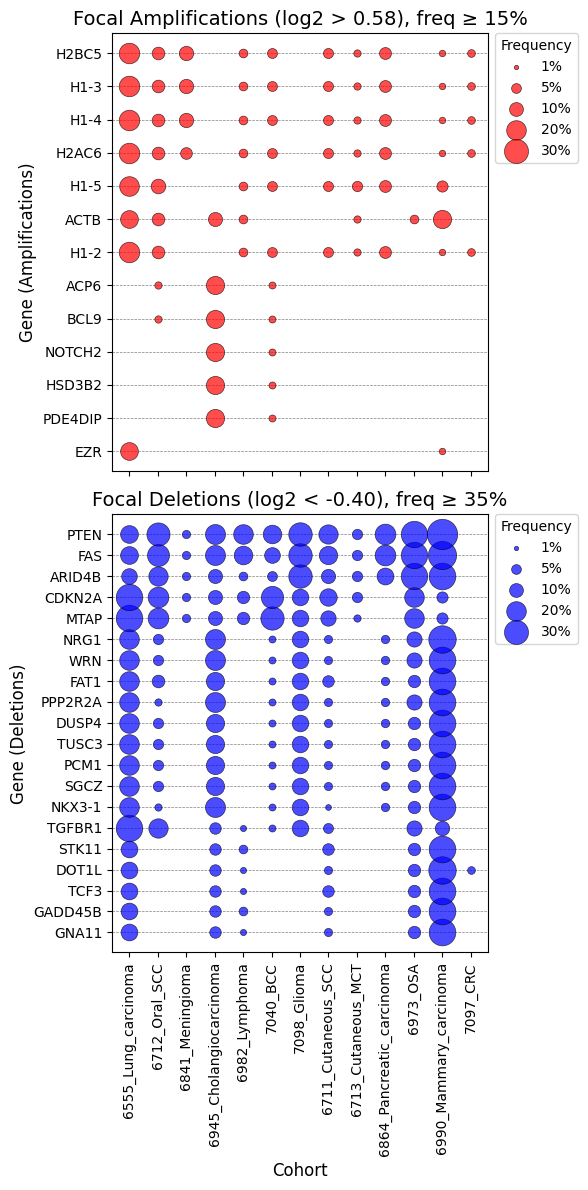

In [14]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 1_000_000_000_000      # Only segments < 1 Mb are considered focal.
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585.
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4.
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Frequency filters: separate thresholds for gains and losses.
MIN_FREQ_THRESHOLD_GAIN = 0.15  # e.g., 10% for gains.
MIN_FREQ_THRESHOLD_LOSS = 0.35   # e.g., 5% for losses.

# Provide the path to the BED file for unnamed genes.
# The BED file is expected to have no header and five columns:
# col0: dummy (always "-"), col1: Ensembl gene ID, col2: chromosome,
# col3: start coordinate, col4: end coordinate.
UNNAMED_GENES_BED_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/unnamed_genes.bed"  # <-- Update as needed

# Provide the path to the exclude file.
# This file contains sample IDs (one per line) to be excluded.
EXCLUDE_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/fur_cat.mad_filtering.samples_to_remove.txt"  # <-- Update as needed

# ---------------------------
# LOAD EXCLUDE FILE
# ---------------------------
exclude_set = set()
if os.path.exists(EXCLUDE_FILE):
    with open(EXCLUDE_FILE, 'r') as f:
        for line in f:
            sample_id = line.strip()
            if sample_id:
                exclude_set.add(sample_id)
    print(f"[INFO] Loaded {len(exclude_set)} sample IDs to exclude.")
else:
    print("[INFO] No exclude file provided or file not found.")

# ---------------------------
# HELPER FUNCTION: Replace Unnamed Gene Tokens with All Matches
# ---------------------------
def replace_gene_names_strict(gene_field, seg_chrom, seg_start, seg_end, bed_df):
    """
    Given a gene_field (a comma-separated string of gene tokens),
    if any token is "-", replace it by finding ALL BED rows for which the
    BED interval is fully contained within the focal segment (i.e. seg_start <= bed_start and seg_end >= bed_end)
    and the chromosome matches. All matching Ensembl gene IDs will be included.
    If no match is found, the "-" token is dropped.
    """
    tokens = [token.strip() for token in gene_field.split(",")]
    new_tokens = []
    for token in tokens:
        if token != "-":
            new_tokens.append(token)
        else:
            # For a "-" token, iterate over all rows in bed_df and add all matches.
            for _, bed_row in bed_df.iterrows():
                bed_chrom = str(bed_row["chrom"])
                try:
                    bed_start = int(bed_row["bed_start"])
                    bed_end   = int(bed_row["bed_end"])
                except Exception:
                    continue
                # Strict containment check: BED interval must be fully contained within the focal segment.
                if seg_chrom == bed_chrom and seg_start <= bed_start and seg_end >= bed_end:
                    new_tokens.append(bed_row["ensembl"])
            # Do not re-append "-" if no match is found.
    new_tokens = sorted(set(new_tokens))
    return ",".join(new_tokens)

# ---------------------------
# LOAD BED FILE FOR UNNAMED GENES (if provided)
# ---------------------------
bed_df = None
if os.path.exists(UNNAMED_GENES_BED_FILE):
    bed_df = pd.read_csv(UNNAMED_GENES_BED_FILE, sep="\t", header=None)
    bed_df.columns = ["dummy", "ensembl", "chrom", "bed_start", "bed_end"]
    print(f"[INFO] Loaded {len(bed_df)} unnamed gene entries from BED file.")
else:
    print("[INFO] No BED file for unnamed genes provided or file not found.")

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}    # To store counts of amplifications (gains) per gene per cohort.
del_counts = {}    # To store counts of deletions (losses) per gene per cohort.
total_samples = {} # To store number of samples per cohort.

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    # Exclude samples based on the exclude file.
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples[cohort] = len(non_excluded_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        # If a BED file is provided, update the "gene" column using strict containment logic.
        if bed_df is not None:
            # Assumes the segmentation file has a "chromosome" column.
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]
        
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes = set()
        sample_del_genes = set()
        
        # Process amplification calls.
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)
        
        # Process deletion calls.
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)
        
        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

# ---------------------------
# REMOVE ANY LEFTOVER "-" ROWS (just in case)
# ---------------------------
if "-" in amp_freq_df.index:
    amp_freq_df = amp_freq_df.drop("-", axis=0)
if "-" in del_freq_df.index:
    del_freq_df = del_freq_df.drop("-", axis=0)

# ---------------------------
# FILTER & ORDER GENES SEPARATELY FOR GAINS & LOSSES
# ---------------------------
# For Amplifications (Gains)
amp_freq_df["max_freq"] = amp_freq_df.max(axis=1)
filtered_amp_freq_df = amp_freq_df[amp_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD_GAIN].drop(columns="max_freq")
filtered_amp_freq_df = filtered_amp_freq_df.assign(avg_freq=filtered_amp_freq_df.mean(axis=1))\
                                           .sort_values("avg_freq", ascending=True)\
                                           .drop(columns="avg_freq")
# For Deletions (Losses)
del_freq_df["max_freq"] = del_freq_df.max(axis=1)
filtered_del_freq_df = del_freq_df[del_freq_df["max_freq"] >= MIN_FREQ_THRESHOLD_LOSS].drop(columns="max_freq")
filtered_del_freq_df = filtered_del_freq_df.assign(avg_freq=filtered_del_freq_df.mean(axis=1))\
                                           .sort_values("avg_freq", ascending=True)\
                                           .drop(columns="avg_freq")

amp_freq_df = filtered_amp_freq_df
del_freq_df = filtered_del_freq_df

# ---------------------------
# CREATE STACKED BUBBLE PLOTS (Shared X-Axis) WITH LEGENDS
# ---------------------------
fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 12), sharex=True)
size_scale = 1000

# --- Amplifications (Top Plot) ---
for i, gene in enumerate(amp_freq_df.index):
    for j, cohort in enumerate(amp_freq_df.columns):
        freq = amp_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_amp.set_title(f"Focal Amplifications (log2 > {GAIN_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD_GAIN:.0%}",
                 fontsize=14)
ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12)
ax_amp.set_yticks(range(len(amp_freq_df.index)))
ax_amp.set_yticklabels(amp_freq_df.index, fontsize=10)
ax_amp.set_xticks(range(len(amp_freq_df.columns)))
ax_amp.set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
ax_amp.set_axisbelow(True)
ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Add legend for amplification bubbles outside the plot area.
legend_sizes_amp = [0.01, 0.05, 0.10, 0.20, 0.30]  # Example frequency values.
legend_handles_amp = [plt.scatter([], [], s=f * size_scale, color='red', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_amp]
legend_labels_amp = [f"{f:.0%}" for f in legend_sizes_amp]
ax_amp.legend(legend_handles_amp, legend_labels_amp, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

# --- Deletions (Bottom Plot) ---
for i, gene in enumerate(del_freq_df.index):
    for j, cohort in enumerate(del_freq_df.columns):
        freq = del_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_del.set_title(f"Focal Deletions (log2 < {LOSS_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD_LOSS:.0%}",
                 fontsize=14)
ax_del.set_ylabel("Gene (Deletions)", fontsize=12)
ax_del.set_xlabel("Cohort", fontsize=12)
ax_del.set_yticks(range(len(del_freq_df.index)))
ax_del.set_yticklabels(del_freq_df.index, fontsize=10)
ax_del.set_xticks(range(len(del_freq_df.columns)))
ax_del.set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
ax_del.set_axisbelow(True)
ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

# Add legend for deletion bubbles outside the plot area.
legend_sizes_del = [0.01, 0.05, 0.10, 0.20, 0.30]
legend_handles_del = [plt.scatter([], [], s=f * size_scale, color='blue', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_del]
legend_labels_del = [f"{f:.0%}" for f in legend_sizes_del]
ax_del.legend(legend_handles_del, legend_labels_del, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.savefig("focal_amp_del_bubble_plots_strict_containment_no_dash_multimatch_exclude.png", dpi=300)
plt.show()


[INFO] Loaded 66 sample IDs to exclude.
[INFO] Loaded 51 unnamed gene entries from BED file.
[INFO] Processing cohort '6555_Lung_carcinoma': 55 sample(s) after exclusion.
[INFO] Processing cohort '6712_Oral_SCC': 36 sample(s) after exclusion.
[INFO] Processing cohort '6841_Meningioma': 28 sample(s) after exclusion.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 29 sample(s) after exclusion.
[INFO] Processing cohort '6982_Lymphoma': 50 sample(s) after exclusion.
[INFO] Processing cohort '7040_BCC': 39 sample(s) after exclusion.
[INFO] Processing cohort '7098_Glioma': 7 sample(s) after exclusion.
[INFO] Processing cohort '6711_Cutaneous_SCC': 57 sample(s) after exclusion.
[INFO] Processing cohort '6713_Cutaneous_MCT': 36 sample(s) after exclusion.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 27 sample(s) after exclusion.
[INFO] Processing cohort '6973_OSA': 25 sample(s) after exclusion.
[INFO] Processing cohort '6990_Mammary_carcinoma': 46 sample(s) after exclusion.
[INFO] 

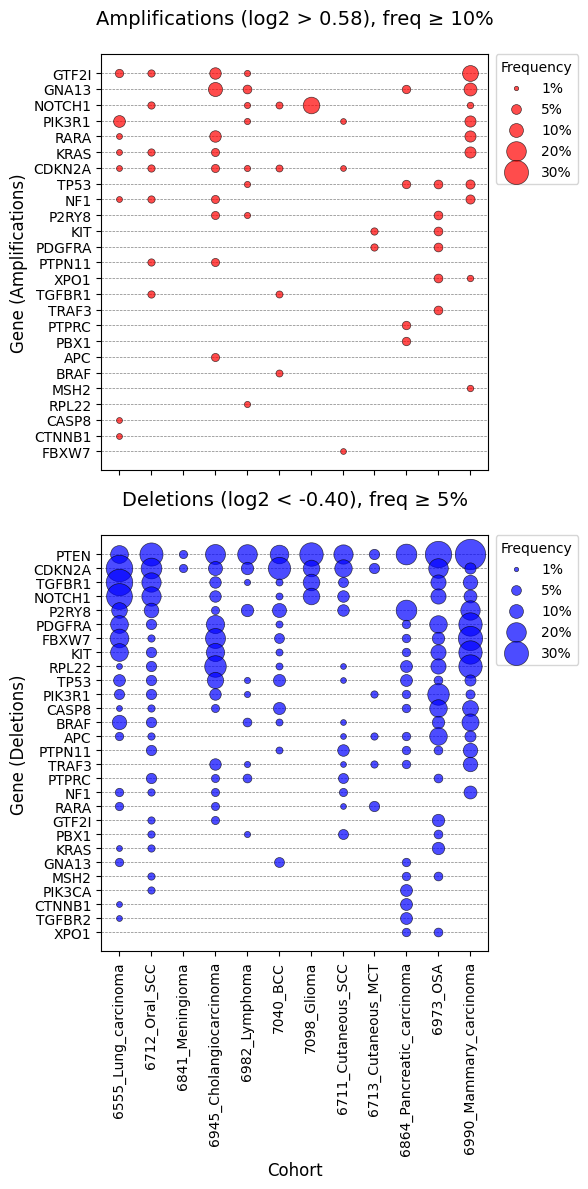

In [20]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 1_000_000_000_000      # Only segments < 1 Mb are considered focal.
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585.
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4.
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Separate frequency thresholds for gains and losses.
MIN_FREQ_THRESHOLD_GAIN = 0.10   # For gains (e.g., 10%).
MIN_FREQ_THRESHOLD_LOSS = 0.05   # For losses (e.g., 5%).

# Provide the path to the BED file for unnamed genes.
# Expected BED file format (no header, 5 columns):
# col0: dummy (always "-"), col1: Ensembl gene ID, col2: chromosome,
# col3: start coordinate, col4: end coordinate.
UNNAMED_GENES_BED_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/unnamed_genes.bed"

# Provide the path to the exclude file.
# This file contains sample IDs (one per line) to be excluded.
EXCLUDE_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/fur_cat.mad_filtering.samples_to_remove.txt"

# List of gene symbols to plot.
GENES_OF_INTEREST = [
    "APC",
    "BRAF",
    "CASP8",
    "CDKN2A",
    "CTNNB1",
    "FBXW7",
    "GNA13",
    "GTF2I",
    "KIT",
    "KRAS",
    "MSH2",
    "NF1",
    "NOTCH1",
    "P2RY8",
    "PBX1",
    "PDGFRA",
    "PIK3CA",
    "PIK3R1",
    "PTEN",
    "PTPN11",
    "PTPRC",
    "RARA",
    "RPL22",
    "TGFBR1",
    "TGFBR2",
    "TP53",
    "TRAF3",
    "XPO1"
]

# ---------------------------
# LOAD EXCLUDE FILE
# ---------------------------
exclude_set = set()
if os.path.exists(EXCLUDE_FILE):
    with open(EXCLUDE_FILE, 'r') as f:
        for line in f:
            sample_id = line.strip()
            if sample_id:
                exclude_set.add(sample_id)
    print(f"[INFO] Loaded {len(exclude_set)} sample IDs to exclude.")
else:
    print("[INFO] No exclude file provided or file not found.")

# ---------------------------
# HELPER FUNCTION: Replace Unnamed Gene Tokens with All Matches
# ---------------------------
def replace_gene_names_strict(gene_field, seg_chrom, seg_start, seg_end, bed_df):
    """
    Given a gene_field (a comma-separated string of gene tokens),
    if any token is "-", replace it by finding ALL BED rows for which the
    BED interval is fully contained within the focal segment (i.e. seg_start <= bed_start and seg_end >= bed_end)
    and the chromosome matches. All matching Ensembl gene IDs will be included.
    If no match is found, the "-" token is dropped.
    """
    tokens = [token.strip() for token in gene_field.split(",")]
    new_tokens = []
    for token in tokens:
        if token != "-":
            new_tokens.append(token)
        else:
            for _, bed_row in bed_df.iterrows():
                bed_chrom = str(bed_row["chrom"])
                try:
                    bed_start = int(bed_row["bed_start"])
                    bed_end   = int(bed_row["bed_end"])
                except Exception:
                    continue
                if seg_chrom == bed_chrom and seg_start <= bed_start and seg_end >= bed_end:
                    new_tokens.append(bed_row["ensembl"])
    new_tokens = sorted(set(new_tokens))
    return ",".join(new_tokens)

# ---------------------------
# LOAD BED FILE FOR UNNAMED GENES (if provided)
# ---------------------------
bed_df = None
if os.path.exists(UNNAMED_GENES_BED_FILE):
    bed_df = pd.read_csv(UNNAMED_GENES_BED_FILE, sep="\t", header=None)
    bed_df.columns = ["dummy", "ensembl", "chrom", "bed_start", "bed_end"]
    print(f"[INFO] Loaded {len(bed_df)} unnamed gene entries from BED file.")
else:
    print("[INFO] No BED file for unnamed genes provided or file not found.")

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

amp_counts = {}    # Counts of amplifications (gains) per gene per cohort.
del_counts = {}    # Counts of deletions (losses) per gene per cohort.
total_samples = {} # Number of samples per cohort.

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    # Exclude samples based on the exclude file.
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples[cohort] = len(non_excluded_files)
    amp_counts[cohort] = {}
    del_counts[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        if bed_df is not None:
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]
        
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes = set()
        sample_del_genes = set()
        
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)
        
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)
        
        for gene in sample_amp_genes:
            amp_counts[cohort][gene] = amp_counts[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts[cohort][gene] = del_counts[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
all_amp_genes = set()
for counts in amp_counts.values():
    all_amp_genes.update(counts.keys())
all_amp_genes = sorted(all_amp_genes)

all_del_genes = set()
for counts in del_counts.values():
    all_del_genes.update(counts.keys())
all_del_genes = sorted(all_del_genes)

amp_freq_df = pd.DataFrame(index=all_amp_genes, columns=amp_counts.keys())
for cohort in amp_counts:
    for gene in all_amp_genes:
        count = amp_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        amp_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
amp_freq_df = amp_freq_df.astype(float)

del_freq_df = pd.DataFrame(index=all_del_genes, columns=del_counts.keys())
for cohort in del_counts:
    for gene in all_del_genes:
        count = del_counts[cohort].get(gene, 0)
        total = total_samples[cohort]
        del_freq_df.loc[gene, cohort] = count / total if total > 0 else 0
del_freq_df = del_freq_df.astype(float)

if "-" in amp_freq_df.index:
    amp_freq_df = amp_freq_df.drop("-", axis=0)
if "-" in del_freq_df.index:
    del_freq_df = del_freq_df.drop("-", axis=0)

# ---------------------------
# FILTER TO INCLUDE ONLY GENES OF INTEREST, THEN ORDER BY AVERAGE FREQUENCY
# ---------------------------
# Subset to genes present in the data and then sort by average frequency (descending).
amp_genes_to_plot = [gene for gene in GENES_OF_INTEREST if gene in amp_freq_df.index]
del_genes_to_plot = [gene for gene in GENES_OF_INTEREST if gene in del_freq_df.index]

amp_freq_df = amp_freq_df.loc[amp_genes_to_plot]
del_freq_df = del_freq_df.loc[del_genes_to_plot]

amp_freq_df = amp_freq_df.assign(avg_freq=amp_freq_df.mean(axis=1))\
                           .sort_values("avg_freq", ascending=False)\
                           .drop(columns="avg_freq")
del_freq_df = del_freq_df.assign(avg_freq=del_freq_df.mean(axis=1))\
                           .sort_values("avg_freq", ascending=False)\
                           .drop(columns="avg_freq")

# ---------------------------
# CREATE STACKED BUBBLE PLOTS (Shared X-Axis) WITH LEGENDS
# ---------------------------
fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 12), sharex=True)
size_scale = 1000

# --- Amplifications (Top Plot) ---
for i, gene in enumerate(amp_freq_df.index):
    for j, cohort in enumerate(amp_freq_df.columns):
        freq = amp_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_amp.set_title(f"Amplifications (log2 > {GAIN_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD_GAIN:.0%}\n", fontsize=14)
ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12)
ax_amp.set_yticks(range(len(amp_freq_df.index)))
ax_amp.set_yticklabels(amp_freq_df.index, fontsize=10)
ax_amp.set_xticks(range(len(amp_freq_df.columns)))
ax_amp.set_xticklabels(amp_freq_df.columns, rotation=90, fontsize=10)
ax_amp.set_axisbelow(True)
ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax_amp.invert_yaxis()  # Invert so highest frequency is at the top.

legend_sizes_amp = [0.01, 0.05, 0.10, 0.20, 0.30]  # Example frequency values.
legend_handles_amp = [plt.scatter([], [], s=f * size_scale, color='red', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_amp]
legend_labels_amp = [f"{f:.0%}" for f in legend_sizes_amp]
ax_amp.legend(legend_handles_amp, legend_labels_amp, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

# --- Deletions (Bottom Plot) ---
for i, gene in enumerate(del_freq_df.index):
    for j, cohort in enumerate(del_freq_df.columns):
        freq = del_freq_df.loc[gene, cohort]
        if freq > 0:
            ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_del.set_title(f"Deletions (log2 < {LOSS_THRESHOLD:.2f}), freq ≥ {MIN_FREQ_THRESHOLD_LOSS:.0%}\n", fontsize=14)
ax_del.set_ylabel("Gene (Deletions)", fontsize=12)
ax_del.set_xlabel("Cohort", fontsize=12)
ax_del.set_yticks(range(len(del_freq_df.index)))
ax_del.set_yticklabels(del_freq_df.index, fontsize=10)
ax_del.set_xticks(range(len(del_freq_df.columns)))
ax_del.set_xticklabels(del_freq_df.columns, rotation=90, fontsize=10)
ax_del.set_axisbelow(True)
ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax_del.invert_yaxis()  # Invert so highest frequency is at the top.

legend_sizes_del = [0.01, 0.05, 0.10, 0.20, 0.30]
legend_handles_del = [plt.scatter([], [], s=f * size_scale, color='blue', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes_del]
legend_labels_del = [f"{f:.0%}" for f in legend_sizes_del]
ax_del.legend(legend_handles_del, legend_labels_del, title="Frequency", loc="upper left",
              bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()
plt.savefig("genes_of_interest_bubble_plots_ordered_by_freq.png", dpi=300)
plt.show()


[INFO] Loaded 66 sample IDs to exclude.
[INFO] Loaded 51 unnamed gene entries from BED file.
[INFO] Processing cohort '6555_Lung_carcinoma': 55 sample(s) after exclusion.
[INFO] Processing cohort '6712_Oral_SCC': 36 sample(s) after exclusion.
[INFO] Processing cohort '6841_Meningioma': 28 sample(s) after exclusion.
[INFO] Processing cohort '6945_Cholangiocarcinoma': 29 sample(s) after exclusion.
[INFO] Processing cohort '6982_Lymphoma': 50 sample(s) after exclusion.
[INFO] Processing cohort '7040_BCC': 39 sample(s) after exclusion.
[INFO] Processing cohort '7098_Glioma': 7 sample(s) after exclusion.
[INFO] Processing cohort '6711_Cutaneous_SCC': 57 sample(s) after exclusion.
[INFO] Processing cohort '6713_Cutaneous_MCT': 36 sample(s) after exclusion.
[INFO] Processing cohort '6864_Pancreatic_carcinoma': 27 sample(s) after exclusion.
[INFO] Processing cohort '6973_OSA': 25 sample(s) after exclusion.
[INFO] Processing cohort '6990_Mammary_carcinoma': 46 sample(s) after exclusion.
[INFO] 

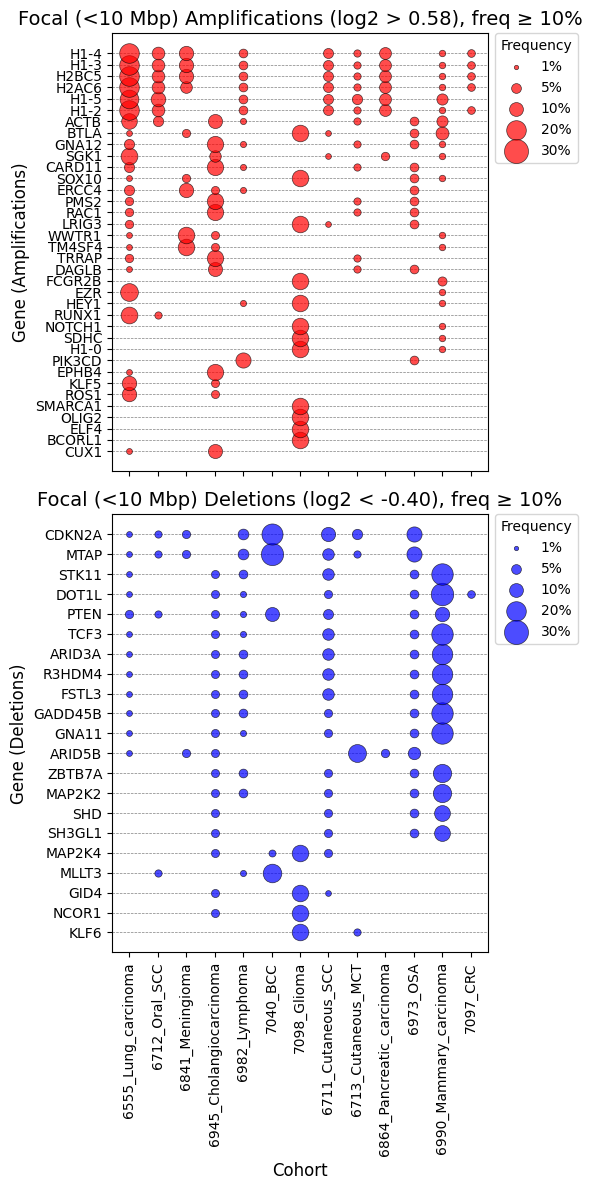

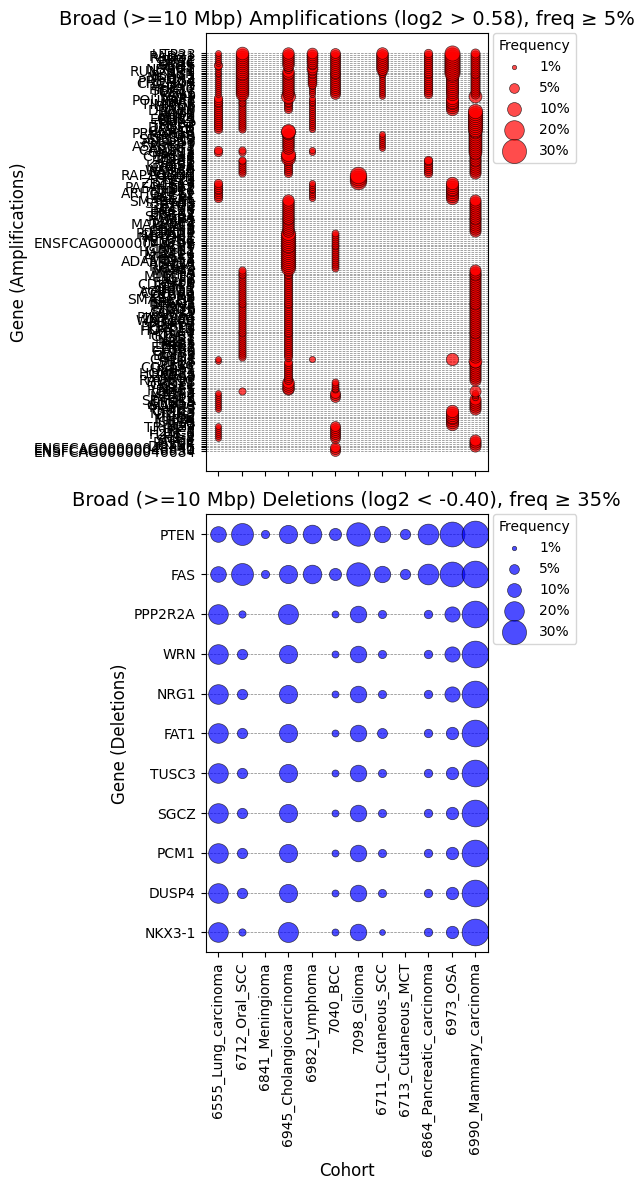

In [26]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# PARAMETERS & SETTINGS
# ---------------------------
FOCAL_THRESHOLD = 10_000_000      # Segments < 10 Mbp are considered focal; segments >= 10 Mbp are considered broad.
GAIN_THRESHOLD = 0.585           # Amplification if log2 > 0.585.
LOSS_THRESHOLD = -0.4            # Deletion if log2 < -0.4.
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"

# Frequency filters for focal events.
MIN_FREQ_THRESHOLD_GAIN_FOCAL = 0.10  # e.g., 10% for focal gains.
MIN_FREQ_THRESHOLD_LOSS_FOCAL = 0.10   # e.g., 10% for focal losses.

# Frequency filters for broad events.
MIN_FREQ_THRESHOLD_GAIN_BROAD = 0.05   # e.g., 15% for broad gains.
MIN_FREQ_THRESHOLD_LOSS_BROAD = 0.35    # e.g., 15% for broad losses.

# Provide the path to the BED file for unnamed genes.
UNNAMED_GENES_BED_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/unnamed_genes.bed"

# Provide the path to the exclude file.
EXCLUDE_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/fur_cat.mad_filtering.samples_to_remove.txt"

# ---------------------------
# LOAD EXCLUDE FILE
# ---------------------------
exclude_set = set()
if os.path.exists(EXCLUDE_FILE):
    with open(EXCLUDE_FILE, 'r') as f:
        for line in f:
            sample_id = line.strip()
            if sample_id:
                exclude_set.add(sample_id)
    print(f"[INFO] Loaded {len(exclude_set)} sample IDs to exclude.")
else:
    print("[INFO] No exclude file provided or file not found.")

# ---------------------------
# HELPER FUNCTION: Replace Unnamed Gene Tokens with All Matches
# ---------------------------
def replace_gene_names_strict(gene_field, seg_chrom, seg_start, seg_end, bed_df):
    """
    Given a gene_field (a comma-separated string of gene tokens),
    if any token is "-", replace it by finding ALL BED rows for which the
    BED interval is fully contained within the segment and the chromosome matches.
    If no match is found, the "-" token is dropped.
    """
    tokens = [token.strip() for token in gene_field.split(",")]
    new_tokens = []
    for token in tokens:
        if token != "-":
            new_tokens.append(token)
        else:
            for _, bed_row in bed_df.iterrows():
                bed_chrom = str(bed_row["chrom"])
                try:
                    bed_start = int(bed_row["bed_start"])
                    bed_end   = int(bed_row["bed_end"])
                except Exception:
                    continue
                if seg_chrom == bed_chrom and seg_start <= bed_start and seg_end >= bed_end:
                    new_tokens.append(bed_row["ensembl"])
    new_tokens = sorted(set(new_tokens))
    return ",".join(new_tokens)

# ---------------------------
# LOAD BED FILE FOR UNNAMED GENES (if provided)
# ---------------------------
bed_df = None
if os.path.exists(UNNAMED_GENES_BED_FILE):
    bed_df = pd.read_csv(UNNAMED_GENES_BED_FILE, sep="\t", header=None)
    bed_df.columns = ["dummy", "ensembl", "chrom", "bed_start", "bed_end"]
    print(f"[INFO] Loaded {len(bed_df)} unnamed gene entries from BED file.")
else:
    print("[INFO] No BED file for unnamed genes provided or file not found.")

# ---------------------------
# LOAD COHORT MAPPING
# ---------------------------
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)

# Dictionaries to hold counts for focal and broad events separately.
amp_counts_focal = {}
del_counts_focal = {}
amp_counts_broad = {}
del_counts_broad = {}
total_samples = {}  # Total sample count per cohort.

# ---------------------------
# PROCESS SEGMENTATION FILES PER COHORT
# ---------------------------
for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    # Exclude samples based on the exclude file.
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples[cohort] = len(non_excluded_files)
    amp_counts_focal[cohort] = {}
    del_counts_focal[cohort] = {}
    amp_counts_broad[cohort] = {}
    del_counts_broad[cohort] = {}
    print(f"[INFO] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        # Update the "gene" column if a BED file is provided.
        if bed_df is not None:
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        # Split segments into focal (<10 Mbp) and broad (>=10 Mbp)
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD]
        broad_df = df[df["segment_length"] >= FOCAL_THRESHOLD]
        
        # ---------------------------
        # Process focal segments
        # ---------------------------
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes_focal = set()
        sample_del_genes_focal = set()
        
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes_focal.add(gene)
        
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes_focal.add(gene)
        
        for gene in sample_amp_genes_focal:
            amp_counts_focal[cohort][gene] = amp_counts_focal[cohort].get(gene, 0) + 1
        for gene in sample_del_genes_focal:
            del_counts_focal[cohort][gene] = del_counts_focal[cohort].get(gene, 0) + 1
        
        # ---------------------------
        # Process broad segments
        # ---------------------------
        broad_amp = broad_df[broad_df["log2"] > GAIN_THRESHOLD]
        broad_del = broad_df[broad_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes_broad = set()
        sample_del_genes_broad = set()
        
        for gene_field in broad_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes_broad.add(gene)
        
        for gene_field in broad_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes_broad.add(gene)
        
        for gene in sample_amp_genes_broad:
            amp_counts_broad[cohort][gene] = amp_counts_broad[cohort].get(gene, 0) + 1
        for gene in sample_del_genes_broad:
            del_counts_broad[cohort][gene] = del_counts_broad[cohort].get(gene, 0) + 1

# ---------------------------
# BUILD FREQUENCY DATAFRAMES
# ---------------------------
def build_freq_df(counts_dict):
    all_genes = set()
    for cohort_counts in counts_dict.values():
        all_genes.update(cohort_counts.keys())
    all_genes = sorted(all_genes)
    freq_df = pd.DataFrame(index=all_genes, columns=counts_dict.keys())
    for cohort in counts_dict:
        for gene in all_genes:
            count = counts_dict[cohort].get(gene, 0)
            total = total_samples[cohort]
            freq_df.loc[gene, cohort] = count / total if total > 0 else 0
    return freq_df.astype(float)

# For focal events.
amp_freq_df_focal = build_freq_df(amp_counts_focal)
del_freq_df_focal = build_freq_df(del_counts_focal)
# For broad events.
amp_freq_df_broad = build_freq_df(amp_counts_broad)
del_freq_df_broad = build_freq_df(del_counts_broad)

# ---------------------------
# OPTIONAL: Remove any leftover "-" rows (if present)
# ---------------------------
for df in [amp_freq_df_focal, del_freq_df_focal, amp_freq_df_broad, del_freq_df_broad]:
    if "-" in df.index:
        df.drop("-", axis=0, inplace=True)

# ---------------------------
# FILTER & ORDER GENES BASED ON MINIMUM FREQUENCY
# ---------------------------
def filter_and_order(freq_df, min_freq):
    freq_df["max_freq"] = freq_df.max(axis=1)
    filtered = freq_df[freq_df["max_freq"] >= min_freq].drop(columns="max_freq")
    filtered = filtered.assign(avg_freq=filtered.mean(axis=1))\
                       .sort_values("avg_freq", ascending=True)\
                       .drop(columns="avg_freq")
    return filtered

# Apply different thresholds for focal and broad events.
amp_freq_df_focal = filter_and_order(amp_freq_df_focal, MIN_FREQ_THRESHOLD_GAIN_FOCAL)
del_freq_df_focal = filter_and_order(del_freq_df_focal, MIN_FREQ_THRESHOLD_LOSS_FOCAL)
amp_freq_df_broad = filter_and_order(amp_freq_df_broad, MIN_FREQ_THRESHOLD_GAIN_BROAD)
del_freq_df_broad = filter_and_order(del_freq_df_broad, MIN_FREQ_THRESHOLD_LOSS_BROAD)

# ---------------------------
# PLOTTING FUNCTION: Create Stacked Bubble Plot for a Given Pair of DataFrames
# ---------------------------
def create_bubble_plot(amp_df, del_df, title_prefix, filename, freq_thresh_gain, freq_thresh_loss):
    fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 12), sharex=True)
    size_scale = 1000

    # Amplifications plot.
    for i, gene in enumerate(amp_df.index):
        for j, cohort in enumerate(amp_df.columns):
            freq = amp_df.loc[gene, cohort]
            if freq > 0:
                ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                               edgecolors='k', linewidth=0.5)
    ax_amp.set_title(f"{title_prefix} Amplifications (log2 > {GAIN_THRESHOLD:.2f}), freq ≥ {freq_thresh_gain:.0%}", fontsize=14)
    ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12)
    ax_amp.set_yticks(range(len(amp_df.index)))
    ax_amp.set_yticklabels(amp_df.index, fontsize=10)
    ax_amp.set_xticks(range(len(amp_df.columns)))
    ax_amp.set_xticklabels(amp_df.columns, rotation=90, fontsize=10)
    ax_amp.set_axisbelow(True)
    ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

    # Legend for amplifications.
    legend_sizes = [0.01, 0.05, 0.10, 0.20, 0.30]
    legend_handles = [plt.scatter([], [], s=f * size_scale, color='red', alpha=0.7,
                                  edgecolors='k', linewidth=0.5) for f in legend_sizes]
    legend_labels = [f"{f:.0%}" for f in legend_sizes]
    ax_amp.legend(legend_handles, legend_labels, title="Frequency", loc="upper left",
                  bbox_to_anchor=(1.02, 1), borderaxespad=0)

    # Deletions plot.
    for i, gene in enumerate(del_df.index):
        for j, cohort in enumerate(del_df.columns):
            freq = del_df.loc[gene, cohort]
            if freq > 0:
                ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                               edgecolors='k', linewidth=0.5)
    ax_del.set_title(f"{title_prefix} Deletions (log2 < {LOSS_THRESHOLD:.2f}), freq ≥ {freq_thresh_loss:.0%}", fontsize=14)
    ax_del.set_ylabel("Gene (Deletions)", fontsize=12)
    ax_del.set_xlabel("Cohort", fontsize=12)
    ax_del.set_yticks(range(len(del_df.index)))
    ax_del.set_yticklabels(del_df.index, fontsize=10)
    ax_del.set_xticks(range(len(del_df.columns)))
    ax_del.set_xticklabels(del_df.columns, rotation=90, fontsize=10)
    ax_del.set_axisbelow(True)
    ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

    # Legend for deletions.
    legend_handles_del = [plt.scatter([], [], s=f * size_scale, color='blue', alpha=0.7,
                                      edgecolors='k', linewidth=0.5) for f in legend_sizes]
    legend_labels_del = [f"{f:.0%}" for f in legend_sizes]
    ax_del.legend(legend_handles_del, legend_labels_del, title="Frequency", loc="upper left",
                  bbox_to_anchor=(1.02, 1), borderaxespad=0)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# ---------------------------
# CREATE THE TWO PLOTS
# ---------------------------
# Plot for focal (<10 Mbp) events.
create_bubble_plot(amp_freq_df_focal, del_freq_df_focal,
                   title_prefix="Focal (<10 Mbp)",
                   filename="focal_amp_del_bubble_plots.png",
                   freq_thresh_gain=MIN_FREQ_THRESHOLD_GAIN_FOCAL,
                   freq_thresh_loss=MIN_FREQ_THRESHOLD_LOSS_FOCAL)

# Plot for broad (>=10 Mbp) events.
create_bubble_plot(amp_freq_df_broad, del_freq_df_broad,
                   title_prefix="Broad (>=10 Mbp)",
                   filename="broad_amp_del_bubble_plots.png",
                   freq_thresh_gain=MIN_FREQ_THRESHOLD_GAIN_BROAD,
                   freq_thresh_loss=MIN_FREQ_THRESHOLD_LOSS_BROAD)


[INFO] Loaded 66 sample IDs to exclude.
[INFO] Loaded 51 unnamed gene entries from BED file.
[INFO] Loaded gene-chromosome mapping for 928 genes.
[INFO] [Analysis 1] Processing cohort '6555_Lung_carcinoma': 55 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6712_Oral_SCC': 36 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6841_Meningioma': 28 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6945_Cholangiocarcinoma': 29 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6982_Lymphoma': 50 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '7040_BCC': 39 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '7098_Glioma': 7 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6711_Cutaneous_SCC': 57 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6713_Cutaneous_MCT': 36 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6864_Pancreatic_carcinoma': 27

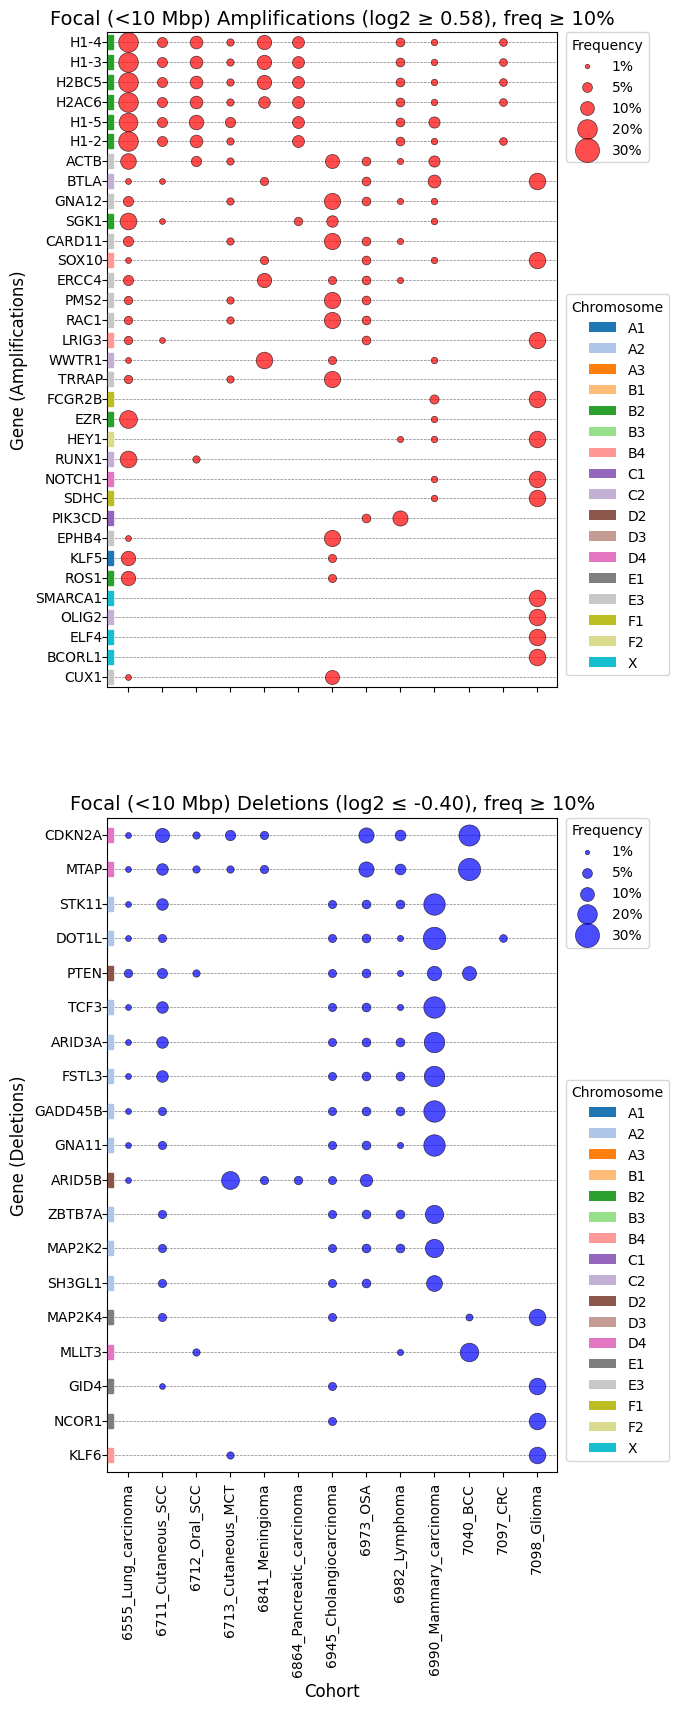

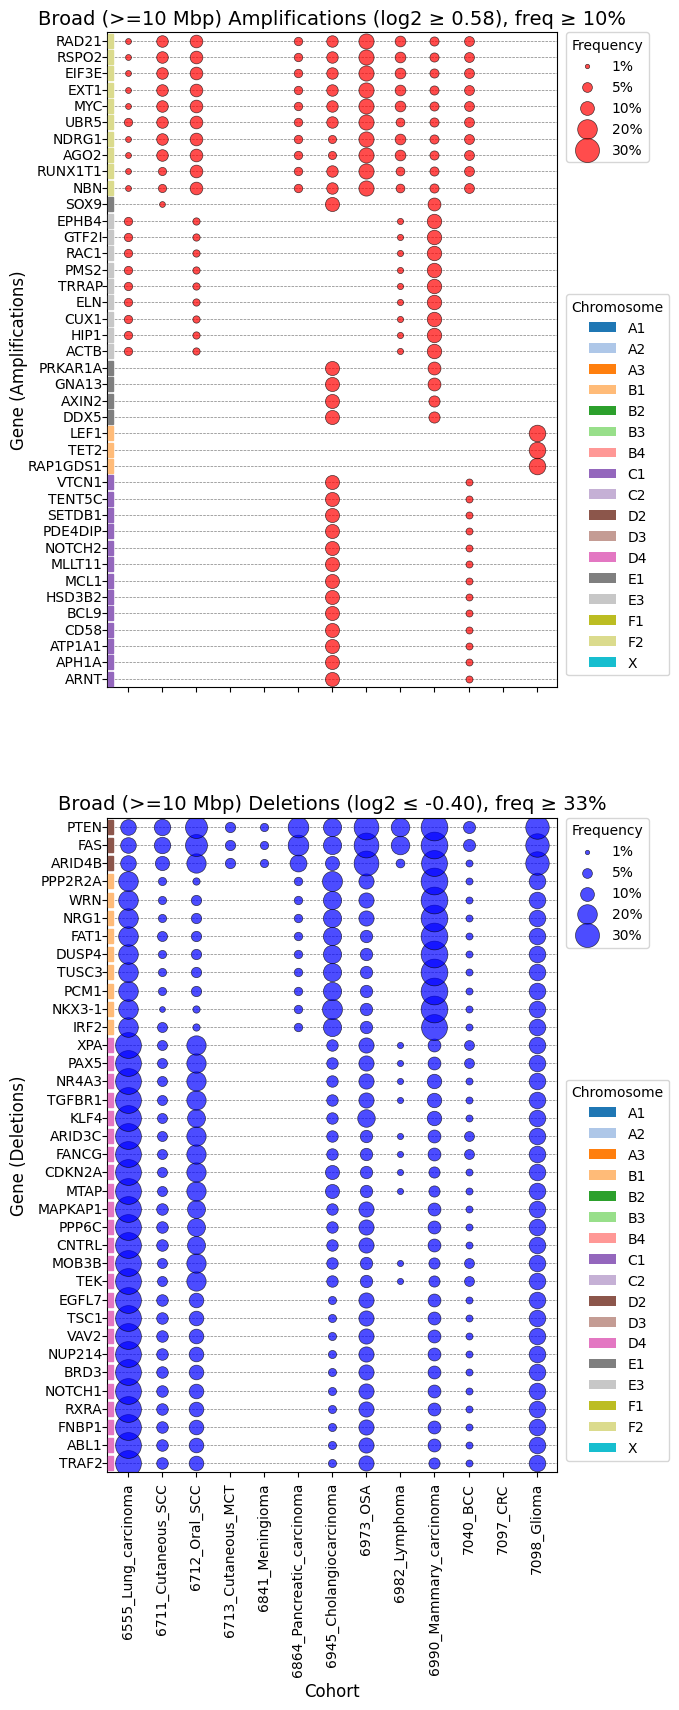

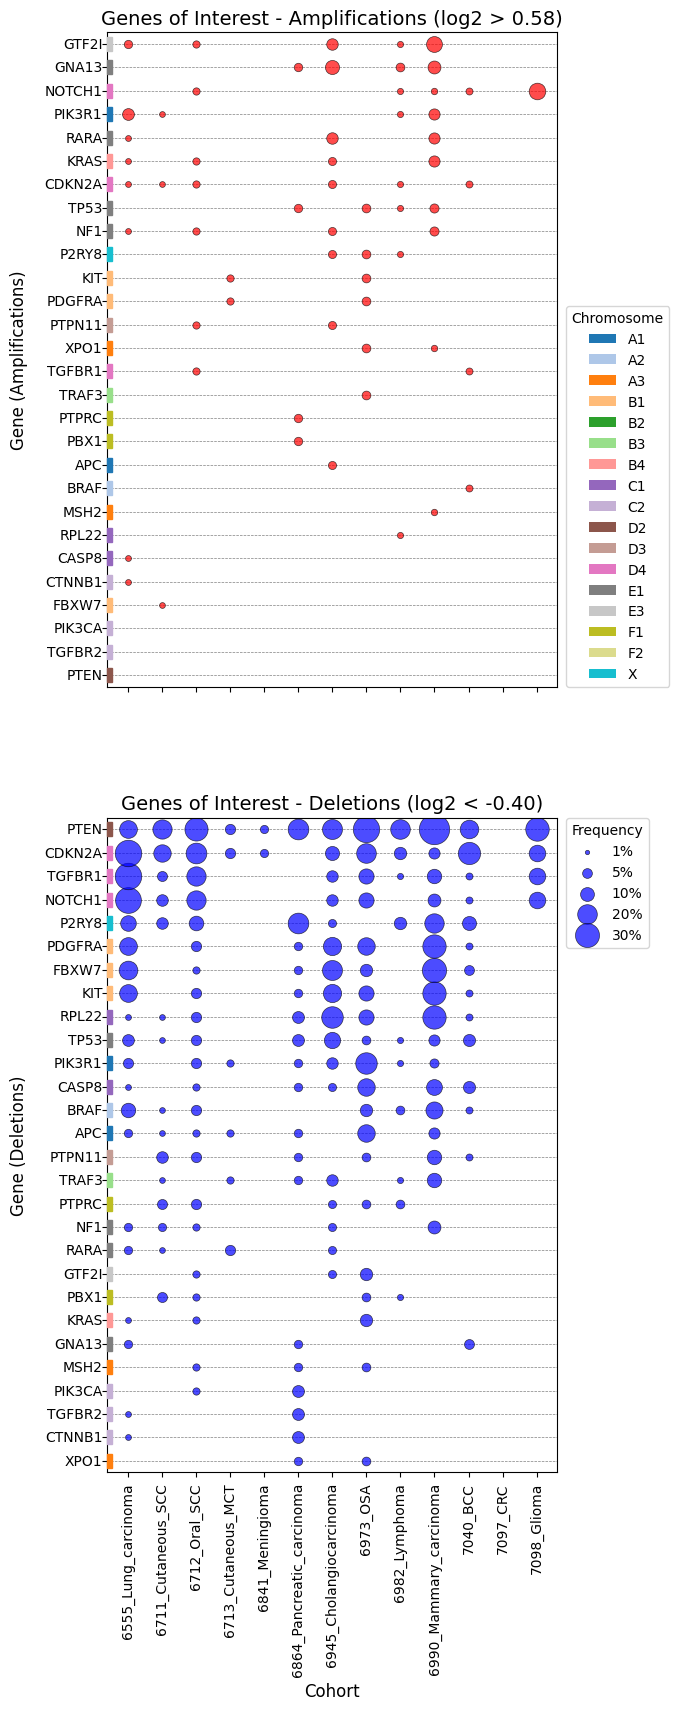

In [11]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FixedLocator

# =============================================================================
# PARAMETERS & SETTINGS
# =============================================================================

GAIN_THRESHOLD = 0.585
LOSS_THRESHOLD = -0.4
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"
UNNAMED_GENES_BED_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/unnamed_genes.bed"
EXCLUDE_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/fur_cat.mad_filtering.samples_to_remove.txt"

FOCAL_THRESHOLD_A1 = 10_000_000
MIN_FREQ_THRESHOLD_GAIN_FOCAL = 0.10
MIN_FREQ_THRESHOLD_LOSS_FOCAL = 0.10
MIN_FREQ_THRESHOLD_GAIN_BROAD = 0.10
MIN_FREQ_THRESHOLD_LOSS_BROAD = 0.33

FOCAL_THRESHOLD_A2 = 1_000_000_000_000
GENES_OF_INTEREST = [
    "APC", "BRAF", "CASP8", "CDKN2A", "CTNNB1", "FBXW7", "GNA13", "GTF2I",
    "KIT", "KRAS", "MSH2", "NF1", "NOTCH1", "P2RY8", "PBX1", "PDGFRA",
    "PIK3CA", "PIK3R1", "PTEN", "PTPN11", "PTPRC", "RARA", "RPL22",
    "TGFBR1", "TGFBR2", "TP53", "TRAF3", "XPO1"
]

GENE_CHROM_MAPPING_FILE = (
    "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/"
    "Felis_catus_9.0.gene_chromosome_mapping.txt"
)

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def replace_gene_names_strict(gene_field, seg_chrom, seg_start, seg_end, bed_df):
    tokens = [token.strip() for token in gene_field.split(",")]
    new_tokens = []
    for token in tokens:
        if token != "-":
            new_tokens.append(token)
        else:
            for _, bed_row in bed_df.iterrows():
                bed_chrom = str(bed_row["chrom"])
                try:
                    bed_start = int(bed_row["bed_start"])
                    bed_end   = int(bed_row["bed_end"])
                except Exception:
                    continue
                if seg_chrom == bed_chrom and seg_start <= bed_start and seg_end >= bed_end:
                    new_tokens.append(bed_row["ensembl"])
    return ",".join(sorted(set(new_tokens)))

def build_freq_df(counts_dict, total_samples):
    all_genes = set()
    for cohort_counts in counts_dict.values():
        all_genes.update(cohort_counts.keys())
    all_genes = sorted(all_genes)
    freq_df = pd.DataFrame(index=all_genes, columns=counts_dict.keys())
    for cohort in counts_dict:
        for gene in all_genes:
            count = counts_dict[cohort].get(gene, 0)
            total = total_samples[cohort]
            freq_df.loc[gene, cohort] = count / total if total > 0 else 0
    return freq_df.astype(float)

def filter_and_order(freq_df, min_freq):
    freq_df["max_freq"] = freq_df.max(axis=1)
    filtered = freq_df[freq_df["max_freq"] >= min_freq].drop(columns="max_freq")
    filtered = (filtered.assign(avg_freq=filtered.mean(axis=1))
                       .sort_values("avg_freq", ascending=True)
                       .drop(columns="avg_freq"))
    return filtered

def draw_labels_and_blocks(
    ax, df, gene_chrom_dict, chrom_color_dict,
    label_xpos=-0.01,
    block_xpos=0.00235  # Use the same offset in ALL plots
):
    """
    1) Fix the y-axis to have exactly len(df.index) ticks at integer positions.
    2) Clear default tick labels.
    3) Manually place each gene label and color block at the same offsets
       so that block positioning is consistent across all plots.
    """
    n_genes = len(df.index)
    ax.set_ylim(-0.5, n_genes - 0.5)
    ax.set_yticks(range(n_genes))
    ax.yaxis.set_major_locator(FixedLocator(range(n_genes)))
    ax.set_yticklabels([""] * n_genes)
    
    for i, gene in enumerate(df.index):
        # Place the gene name
        ax.text(label_xpos, i, gene,
                transform=ax.get_yaxis_transform(),
                ha="right", va="center", fontsize=10)
        
        # Place the colored chromosome block if mapped
        if gene in gene_chrom_dict:
            chrom = gene_chrom_dict[gene]
            color = chrom_color_dict.get(chrom, "gray")
            ax.text(block_xpos, i, " ",
                    transform=ax.get_yaxis_transform(),
                    ha="left", va="center",
                    bbox=dict(boxstyle="square,pad=0.0", fc=color, ec=color))

def create_bubble_plot(
    amp_df, del_df, title_prefix, filename,
    freq_thresh_gain, freq_thresh_loss,
    gene_chrom_dict, chrom_color_dict
):
    """
    Creates a stacked bubble plot for amplifications and deletions, removing
    default y-axis labels and placing each gene + color block manually.
    The same block_xpos is used for consistency across all plots.
    """
    fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 16), sharex=True)
    size_scale = 1000

    # ---------- Amplifications ----------
    for i, gene in enumerate(amp_df.index):
        for j, cohort in enumerate(amp_df.columns):
            freq = amp_df.loc[gene, cohort]
            if freq > 0:
                ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                               edgecolors='k', linewidth=0.5)
    ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12, labelpad=50)
    ax_amp.set_title(
        f"{title_prefix} Amplifications (log2 ≥ {GAIN_THRESHOLD:.2f}), freq ≥ {freq_thresh_gain:.0%}",
        fontsize=14
    )
    ax_amp.set_xticks(range(len(amp_df.columns)))
    ax_amp.set_xticklabels(amp_df.columns, rotation=90, fontsize=10)
    ax_amp.set_axisbelow(True)
    ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
    ax_amp.invert_yaxis()

    # Frequency Legend (Amplifications)
    freq_legend_sizes = [0.01, 0.05, 0.10, 0.20, 0.30]
    freq_legend_handles = [
        plt.scatter([], [], s=f * size_scale, color='red', alpha=0.7,
                    edgecolors='k', linewidth=0.5) for f in freq_legend_sizes
    ]
    freq_legend_labels = [f"{f:.0%}" for f in freq_legend_sizes]
    freq_legend_amp = ax_amp.legend(
        freq_legend_handles, freq_legend_labels, title="Frequency",
        loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0
    )

    # Chromosome Legend (Amplifications)
    chrom_legend_patches = [
        Patch(facecolor=clr, label=chrom)
        for chrom, clr in sorted(chrom_color_dict.items())
    ]
    chrom_legend_amp = ax_amp.legend(
        handles=chrom_legend_patches, title="Chromosome",
        loc="upper left", bbox_to_anchor=(1.02, 0.6), borderaxespad=0
    )
    ax_amp.add_artist(freq_legend_amp)  # Keep the frequency legend

    # ---------- Deletions ----------
    for i, gene in enumerate(del_df.index):
        for j, cohort in enumerate(del_df.columns):
            freq = del_df.loc[gene, cohort]
            if freq > 0:
                ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                               edgecolors='k', linewidth=0.5)
    ax_del.set_ylabel("Gene (Deletions)", fontsize=12, labelpad=50)
    ax_del.set_title(
        f"{title_prefix} Deletions (log2 ≤ {LOSS_THRESHOLD:.2f}), freq ≥ {freq_thresh_loss:.0%}",
        fontsize=14
    )
    ax_del.set_xlabel("Cohort", fontsize=12)
    ax_del.set_xticks(range(len(del_df.columns)))
    ax_del.set_xticklabels(del_df.columns, rotation=90, fontsize=10)
    ax_del.set_axisbelow(True)
    ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
    ax_del.invert_yaxis()

    # Frequency Legend (Deletions)
    freq_legend_del_handles = [
        plt.scatter([], [], s=f * size_scale, color='blue', alpha=0.7,
                    edgecolors='k', linewidth=0.5) for f in freq_legend_sizes
    ]
    freq_legend_del = ax_del.legend(
        freq_legend_del_handles, freq_legend_labels, title="Frequency",
        loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0
    )

    # Chromosome Legend (Deletions)
    chrom_legend_del = ax_del.legend(
        handles=chrom_legend_patches, title="Chromosome",
        loc="upper left", bbox_to_anchor=(1.02, 0.6), borderaxespad=0
    )
    ax_del.add_artist(freq_legend_del)  # Keep the frequency legend

    # ---------- Chromosome Annotation (Manual) ----------
    # Use the same block_xpos in draw_labels_and_blocks for consistent positioning.
    draw_labels_and_blocks(
        ax_amp, amp_df, gene_chrom_dict, chrom_color_dict,
        label_xpos=-0.01, block_xpos=0.00235
    )
    draw_labels_and_blocks(
        ax_del, del_df, gene_chrom_dict, chrom_color_dict,
        label_xpos=-0.01, block_xpos=0.00235
    )

    plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()
    
# =============================================================================
# LOAD FILES: EXCLUDE, BED, COHORT MAPPING, GENE-CHROMOSOME MAPPING
# =============================================================================

# Load sample IDs to exclude.
exclude_set = set()
if os.path.exists(EXCLUDE_FILE):
    with open(EXCLUDE_FILE, 'r') as f:
        for line in f:
            sample_id = line.strip()
            if sample_id:
                exclude_set.add(sample_id)
    print(f"[INFO] Loaded %d sample IDs to exclude." % len(exclude_set))
else:
    print("[INFO] No exclude file provided or file not found.")

# Load BED file for unnamed genes.
bed_df = None
if os.path.exists(UNNAMED_GENES_BED_FILE):
    bed_df = pd.read_csv(UNNAMED_GENES_BED_FILE, sep="\t", header=None)
    bed_df.columns = ["dummy", "ensembl", "chrom", "bed_start", "bed_end"]
    print(f"[INFO] Loaded {len(bed_df)} unnamed gene entries from BED file.")
else:
    print("[INFO] No BED file for unnamed genes provided or file not found.")

# Load cohort mapping.
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)
all_cohorts = sorted(cohort_mapping.keys())

# Load gene-to-chromosome mapping.
if os.path.exists(GENE_CHROM_MAPPING_FILE):
    gene_chrom_df = pd.read_csv(GENE_CHROM_MAPPING_FILE, sep="\t", header=None)
    gene_chrom_dict = {}
    for idx, row in gene_chrom_df.iterrows():
        if len(row) == 4:
            # Format: gene, chrom, start, end
            gene = str(row[0]).strip()
            chrom = str(row[1]).strip()
        elif len(row) >= 5:
            # Format: gene symbol, ensembl, chrom, start, end
            if str(row[0]).strip().startswith("ENSFCAG"):
                gene = str(row[0]).strip()
                chrom = str(row[1]).strip()
            else:
                gene = str(row[0]).strip()
                chrom = str(row[2]).strip()
        else:
            continue
        gene_chrom_dict[gene] = chrom
    print(f"[INFO] Loaded gene-chromosome mapping for {len(gene_chrom_dict)} genes.")
else:
    print("[ERROR] Gene-chromosome mapping file not found!")
    gene_chrom_dict = {}

# =============================================================================
# ANALYSIS 1 & 2: BUILD FREQUENCY DATAFRAMES
# (Same logic as before, but we'll unify color assignments at the end.)
# =============================================================================

# 1) Build focal/broad data frames (amp_freq_df_focal, del_freq_df_focal, etc.)
#    Filter out genes not in gene_chrom_dict. Then produce plots.
# 2) Build genes-of-interest data frames (amp_freq_df_A2, del_freq_df_A2).
#    Filter out genes not in gene_chrom_dict. Then produce plots.

# (For brevity, the code is the same as your previous approach.)
#  We'll define placeholders for these data frames below.

###############################################################################
# (1) ANALYSIS 1: FOCAL vs BROAD
###############################################################################
amp_counts_focal = {}
del_counts_focal = {}
amp_counts_broad = {}
del_counts_broad = {}
total_samples_A1 = {}

for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples_A1[cohort] = len(non_excluded_files)
    amp_counts_focal[cohort] = {}
    del_counts_focal[cohort] = {}
    amp_counts_broad[cohort] = {}
    del_counts_broad[cohort] = {}
    print(f"[INFO] [Analysis 1] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        if bed_df is not None:
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD_A1]
        broad_df = df[df["segment_length"] >= FOCAL_THRESHOLD_A1]
        
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes_focal = set()
        sample_del_genes_focal = set()
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes_focal.add(gene)
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes_focal.add(gene)
        
        for gene in sample_amp_genes_focal:
            amp_counts_focal[cohort][gene] = amp_counts_focal[cohort].get(gene, 0) + 1
        for gene in sample_del_genes_focal:
            del_counts_focal[cohort][gene] = del_counts_focal[cohort].get(gene, 0) + 1
        
        broad_amp = broad_df[broad_df["log2"] > GAIN_THRESHOLD]
        broad_del = broad_df[broad_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes_broad = set()
        sample_del_genes_broad = set()
        for gene_field in broad_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes_broad.add(gene)
        for gene_field in broad_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes_broad.add(gene)
        
        for gene in sample_amp_genes_broad:
            amp_counts_broad[cohort][gene] = amp_counts_broad[cohort].get(gene, 0) + 1
        for gene in sample_del_genes_broad:
            del_counts_broad[cohort][gene] = del_counts_broad[cohort].get(gene, 0) + 1

amp_freq_df_focal = build_freq_df(amp_counts_focal, total_samples_A1)
del_freq_df_focal = build_freq_df(del_counts_focal, total_samples_A1)
amp_freq_df_broad = build_freq_df(amp_counts_broad, total_samples_A1)
del_freq_df_broad = build_freq_df(del_counts_broad, total_samples_A1)

amp_freq_df_focal = amp_freq_df_focal.reindex(columns=all_cohorts, fill_value=0)
del_freq_df_focal = del_freq_df_focal.reindex(columns=all_cohorts, fill_value=0)
amp_freq_df_broad = amp_freq_df_broad.reindex(columns=all_cohorts, fill_value=0)
del_freq_df_broad = del_freq_df_broad.reindex(columns=all_cohorts, fill_value=0)

for df_ in [amp_freq_df_focal, del_freq_df_focal, amp_freq_df_broad, del_freq_df_broad]:
    if "-" in df_.index:
        df_.drop("-", axis=0, inplace=True)

amp_freq_df_focal = filter_and_order(amp_freq_df_focal, MIN_FREQ_THRESHOLD_GAIN_FOCAL)
del_freq_df_focal = filter_and_order(del_freq_df_focal, MIN_FREQ_THRESHOLD_LOSS_FOCAL)
amp_freq_df_broad = filter_and_order(amp_freq_df_broad, MIN_FREQ_THRESHOLD_GAIN_BROAD)
del_freq_df_broad = filter_and_order(del_freq_df_broad, MIN_FREQ_THRESHOLD_LOSS_BROAD)

# Filter out any gene not in the gene->chromosome dictionary
amp_freq_df_focal = amp_freq_df_focal.loc[amp_freq_df_focal.index.intersection(gene_chrom_dict.keys())]
del_freq_df_focal = del_freq_df_focal.loc[del_freq_df_focal.index.intersection(gene_chrom_dict.keys())]
amp_freq_df_broad = amp_freq_df_broad.loc[amp_freq_df_broad.index.intersection(gene_chrom_dict.keys())]
del_freq_df_broad = del_freq_df_broad.loc[del_freq_df_broad.index.intersection(gene_chrom_dict.keys())]

###############################################################################
# (2) ANALYSIS 2: GENES OF INTEREST
###############################################################################
amp_counts_A2 = {}
del_counts_A2 = {}
total_samples_A2 = {}

for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples_A2[cohort] = len(non_excluded_files)
    amp_counts_A2[cohort] = {}
    del_counts_A2[cohort] = {}
    print(f"[INFO] [Analysis 2] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        if bed_df is not None:
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD_A2]
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes = set()
        sample_del_genes = set()
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)
        
        for gene in sample_amp_genes:
            amp_counts_A2[cohort][gene] = amp_counts_A2[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts_A2[cohort][gene] = del_counts_A2[cohort].get(gene, 0) + 1

amp_freq_df_A2 = build_freq_df(amp_counts_A2, total_samples_A2)
del_freq_df_A2 = build_freq_df(del_counts_A2, total_samples_A2)

if "-" in amp_freq_df_A2.index:
    amp_freq_df_A2.drop("-", axis=0, inplace=True)
if "-" in del_freq_df_A2.index:
    del_freq_df_A2.drop("-", axis=0, inplace=True)

amp_freq_df_A2 = amp_freq_df_A2.reindex(GENES_OF_INTEREST, fill_value=0)
del_freq_df_A2 = del_freq_df_A2.reindex(GENES_OF_INTEREST, fill_value=0)
amp_freq_df_A2 = amp_freq_df_A2.reindex(columns=all_cohorts, fill_value=0)
del_freq_df_A2 = del_freq_df_A2.reindex(columns=all_cohorts, fill_value=0)

# Filter out any gene not in the gene->chromosome dictionary
common_genes_goi = amp_freq_df_A2.index.intersection(gene_chrom_dict.keys())
amp_freq_df_A2 = amp_freq_df_A2.loc[common_genes_goi]
del_freq_df_A2 = del_freq_df_A2.loc[common_genes_goi]

ordered_genes_amp = amp_freq_df_A2.assign(avg=amp_freq_df_A2.mean(axis=1)).sort_values("avg", ascending=True).index
ordered_genes_del = del_freq_df_A2.assign(avg=del_freq_df_A2.mean(axis=1)).sort_values("avg", ascending=True).index
amp_freq_df_A2 = amp_freq_df_A2.loc[ordered_genes_amp]
del_freq_df_A2 = del_freq_df_A2.loc[ordered_genes_del]

# =============================================================================
# BUILD A SINGLE CHROMOSOME-COLOR DICTIONARY FOR ALL PLOTS
# =============================================================================
all_genes_for_coloring = set()
all_genes_for_coloring.update(amp_freq_df_focal.index)
all_genes_for_coloring.update(del_freq_df_focal.index)
all_genes_for_coloring.update(amp_freq_df_broad.index)
all_genes_for_coloring.update(del_freq_df_broad.index)
all_genes_for_coloring.update(amp_freq_df_A2.index)
all_genes_for_coloring.update(del_freq_df_A2.index)

# Get the union of all chromosomes for these genes
all_chroms_for_coloring = set()
for g in all_genes_for_coloring:
    # g should be in gene_chrom_dict
    all_chroms_for_coloring.add(gene_chrom_dict[g])

unique_chroms = sorted(all_chroms_for_coloring)
cmap = plt.get_cmap("tab20")
chrom_color_dict = {
    chrom: cmap(i / len(unique_chroms)) for i, chrom in enumerate(unique_chroms)
}

# =============================================================================
# PRODUCE THE FOCAL & BROAD PLOTS (Analysis 1)
# =============================================================================
create_bubble_plot(
    amp_freq_df_focal, del_freq_df_focal,
    title_prefix="Focal (<10 Mbp)",
    filename="focal_amp_del_bubble_plots_with_chrom_annotation.pdf",
    freq_thresh_gain=MIN_FREQ_THRESHOLD_GAIN_FOCAL,
    freq_thresh_loss=MIN_FREQ_THRESHOLD_LOSS_FOCAL,
    gene_chrom_dict=gene_chrom_dict,
    chrom_color_dict=chrom_color_dict
)

create_bubble_plot(
    amp_freq_df_broad, del_freq_df_broad,
    title_prefix="Broad (>=10 Mbp)",
    filename="broad_amp_del_bubble_plots_with_chrom_annotation.pdf",
    freq_thresh_gain=MIN_FREQ_THRESHOLD_GAIN_BROAD,
    freq_thresh_loss=MIN_FREQ_THRESHOLD_LOSS_BROAD,
    gene_chrom_dict=gene_chrom_dict,
    chrom_color_dict=chrom_color_dict
)

# =============================================================================
# PRODUCE THE GENES-OF-INTEREST PLOT (Analysis 2)
# =============================================================================

# We'll do a custom plot as in your code, but also reusing the same chrom_color_dict.
fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 16), sharex=True)
size_scale = 1000

# ---------- Amplifications (top) ----------
for i, gene in enumerate(amp_freq_df_A2.index):
    for j, cohort in enumerate(amp_freq_df_A2.columns):
        freq = amp_freq_df_A2.loc[gene, cohort]
        if freq > 0:
            ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_amp.set_title(f"Genes of Interest - Amplifications (log2 > {GAIN_THRESHOLD:.2f})", fontsize=14)
ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12, labelpad=50)
ax_amp.set_xticks(range(len(amp_freq_df_A2.columns)))
ax_amp.set_xticklabels(amp_freq_df_A2.columns, rotation=90, fontsize=10)
ax_amp.set_axisbelow(True)
ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax_amp.invert_yaxis()

legend_sizes_amp = [0.01, 0.05, 0.10, 0.20, 0.30]
legend_handles_amp = [
    plt.scatter([], [], s=f * size_scale, color='red', alpha=0.7,
                edgecolors='k', linewidth=0.5) for f in legend_sizes_amp
]
legend_labels_amp = [f"{f:.0%}" for f in legend_sizes_amp]
ax_amp.legend(
    legend_handles_amp, legend_labels_amp, title="Frequency",
    loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0
)

# ---------- Deletions (bottom) ----------
for i, gene in enumerate(del_freq_df_A2.index):
    for j, cohort in enumerate(del_freq_df_A2.columns):
        freq = del_freq_df_A2.loc[gene, cohort]
        if freq > 0:
            ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                           edgecolors='k', linewidth=0.5)
ax_del.set_title(f"Genes of Interest - Deletions (log2 < {LOSS_THRESHOLD:.2f})", fontsize=14)
ax_del.set_ylabel("Gene (Deletions)", fontsize=12, labelpad=50)
ax_del.set_xlabel("Cohort", fontsize=12)
ax_del.set_xticks(range(len(del_freq_df_A2.columns)))
ax_del.set_xticklabels(del_freq_df_A2.columns, rotation=90, fontsize=10)
ax_del.set_axisbelow(True)
ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax_del.invert_yaxis()

legend_sizes_del = [0.01, 0.05, 0.10, 0.20, 0.30]
legend_handles_del = [
    plt.scatter([], [], s=f * size_scale, color='blue', alpha=0.7,
                edgecolors='k', linewidth=0.5) for f in legend_sizes_del
]
legend_labels_del = [f"{f:.0%}" for f in legend_sizes_del]
ax_del.legend(
    legend_handles_del, legend_labels_del, title="Frequency",
    loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0
)

# --- Chromosome Annotation (manual), reusing the same chrom_color_dict
def fix_yaxis_and_draw(ax, df):
    n_genes = len(df.index)
    ax.set_ylim(-0.5, n_genes - 0.5)
    ax.set_yticks(range(n_genes))
    ax.yaxis.set_major_locator(FixedLocator(range(n_genes)))
    ax.set_yticklabels([""] * n_genes)
    for i, gene in enumerate(df.index):
        ax.text(-0.01, i, gene,
                transform=ax.get_yaxis_transform(),
                ha="right", va="center", fontsize=10)
        chrom = gene_chrom_dict[gene]  # guaranteed to exist
        color = chrom_color_dict.get(chrom, "gray")
        ax.text(0.0, i, " ",
                transform=ax.get_yaxis_transform(),
                ha="left", va="center",
                bbox=dict(boxstyle="square,pad=0.0", fc=color, ec=color))

fix_yaxis_and_draw(ax_amp, amp_freq_df_A2)
fix_yaxis_and_draw(ax_del, del_freq_df_A2)

# Create chromosome legend from the global dictionary
chrom_legend_patches_goi = [
    Patch(facecolor=clr, label=chrom)
    for chrom, clr in sorted(chrom_color_dict.items())
]
ax_amp.legend(
    handles=chrom_legend_patches_goi, title="Chromosome",
    loc="lower left", bbox_to_anchor=(1.02, 0), borderaxespad=0
)

plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)
plt.savefig("genes_of_interest_bubble_plots_with_chrom_annotation.pdf", dpi=600, bbox_inches='tight')
plt.show()


[INFO] Loaded 66 sample IDs to exclude.
[INFO] Loaded 51 unnamed gene entries from BED file.
[INFO] Loaded gene-chromosome mapping for 928 genes.
[INFO] [Analysis 1] Processing cohort '6555_Lung_carcinoma': 55 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6712_Oral_SCC': 36 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6841_Meningioma': 28 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6945_Cholangiocarcinoma': 29 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6982_Lymphoma': 50 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '7040_BCC': 39 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '7098_Glioma': 7 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6711_Cutaneous_SCC': 57 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6713_Cutaneous_MCT': 36 sample(s) after exclusion.
[INFO] [Analysis 1] Processing cohort '6864_Pancreatic_carcinoma': 27

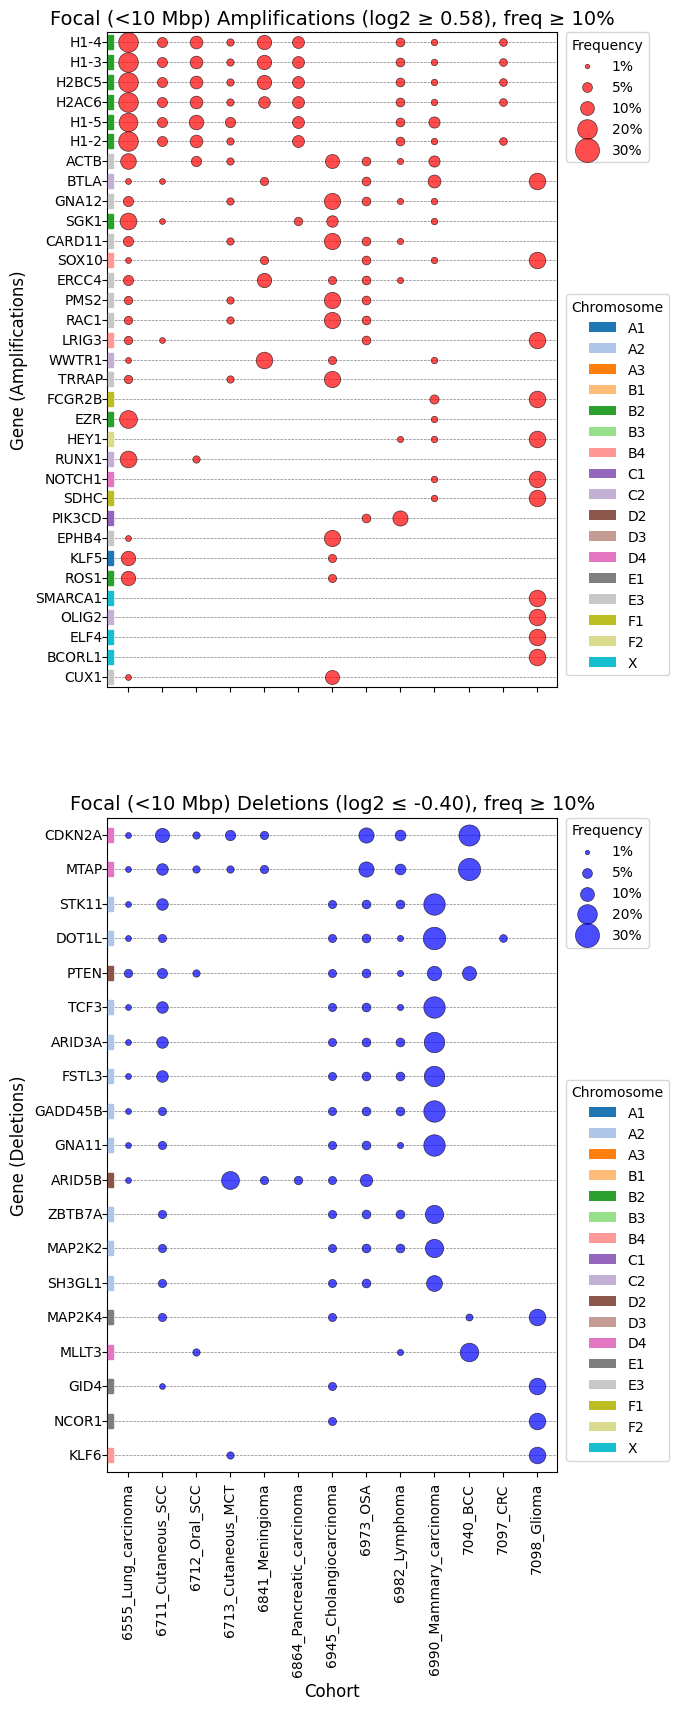

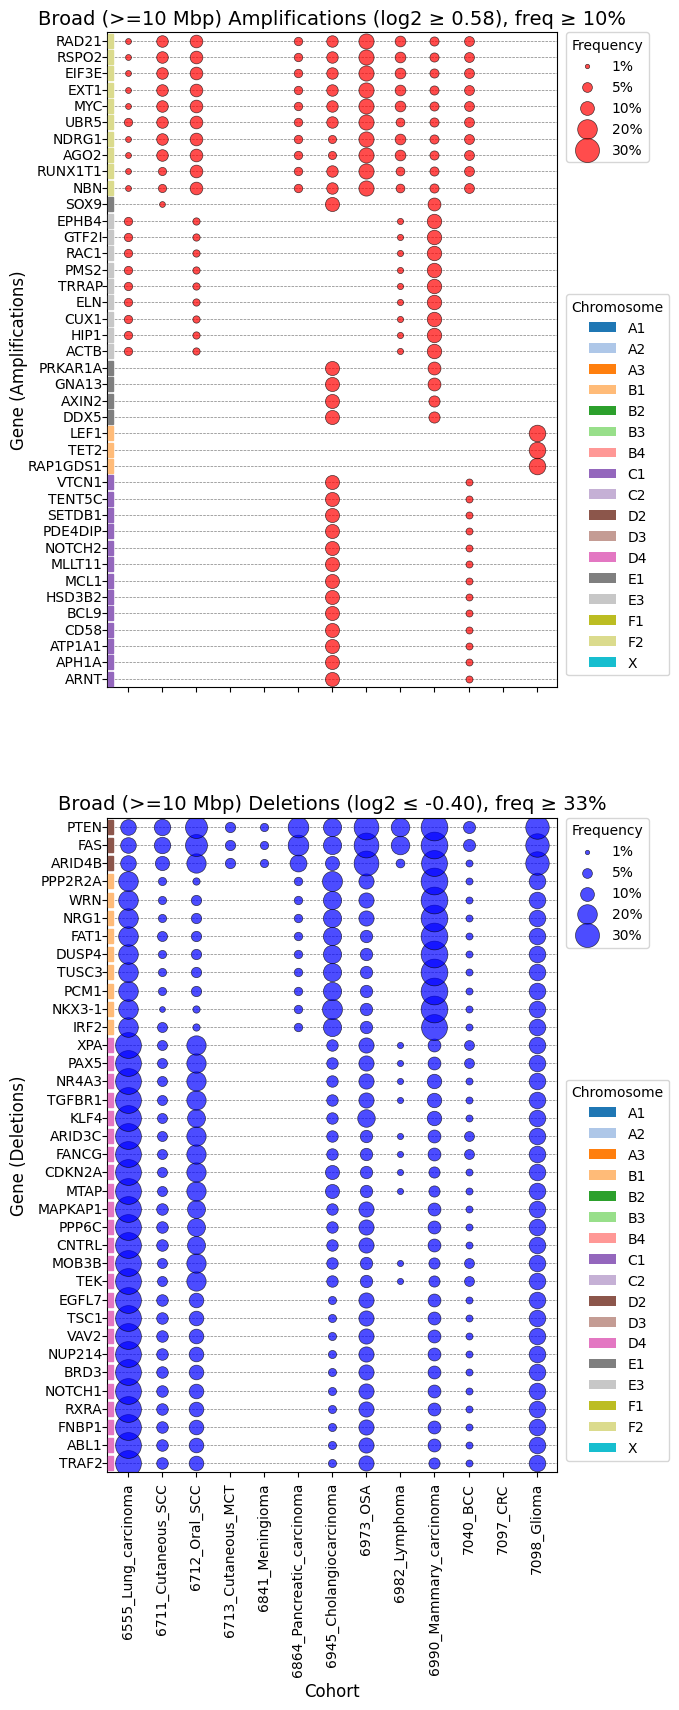

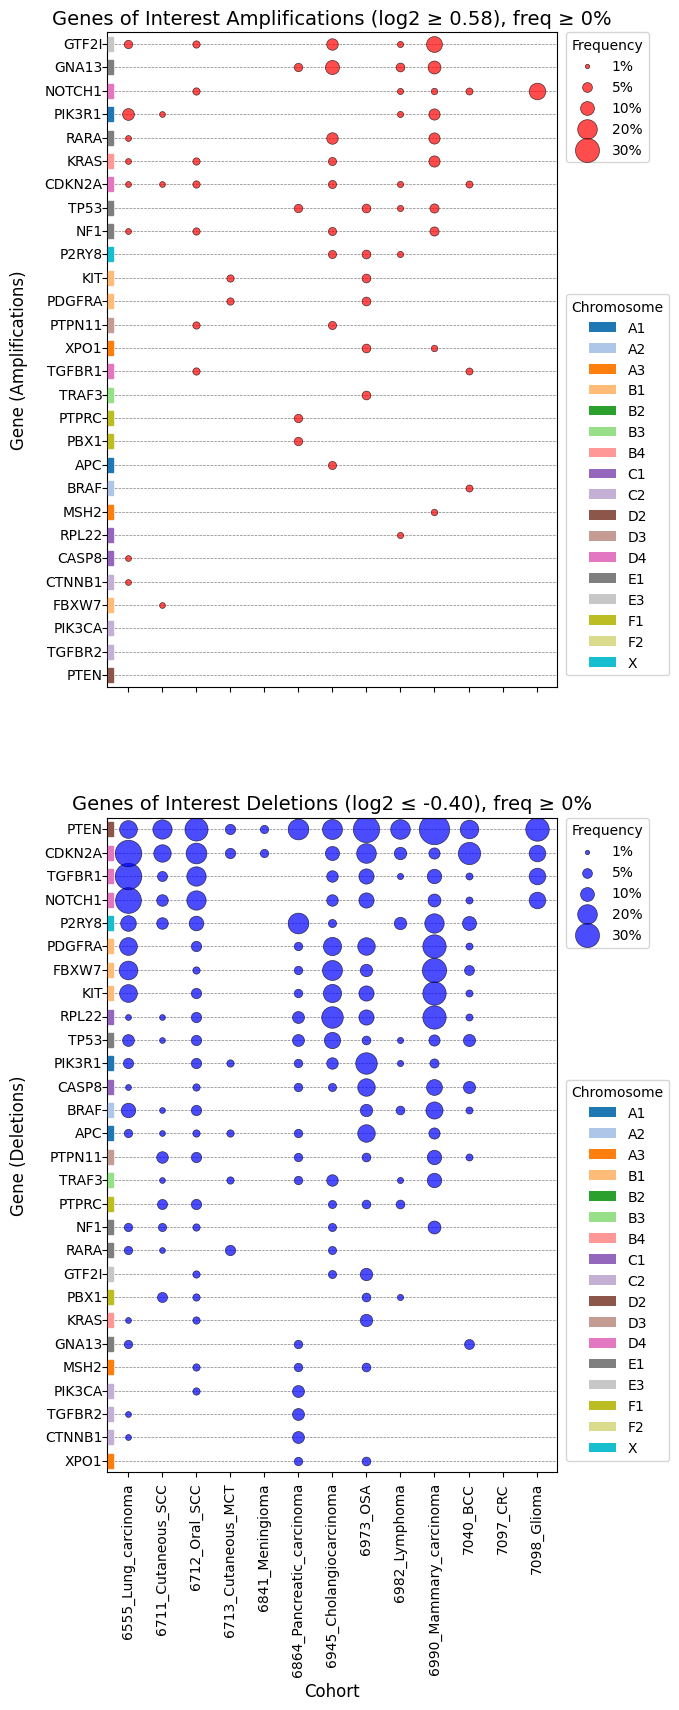

In [12]:
#!/usr/bin/env python3
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FixedLocator

# =============================================================================
# PARAMETERS & SETTINGS
# =============================================================================

GAIN_THRESHOLD = 0.585
LOSS_THRESHOLD = -0.4
EXCLUDED_GENES = {"cmpl", "none", "incmpl"}
COHORT_MAPPING_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/cohort_mapping.json"
UNNAMED_GENES_BED_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/unnamed_genes.bed"
EXCLUDE_FILE = "/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/fur_cat.mad_filtering.samples_to_remove.txt"

FOCAL_THRESHOLD_A1 = 10_000_000
MIN_FREQ_THRESHOLD_GAIN_FOCAL = 0.10
MIN_FREQ_THRESHOLD_LOSS_FOCAL = 0.10
MIN_FREQ_THRESHOLD_GAIN_BROAD = 0.10
MIN_FREQ_THRESHOLD_LOSS_BROAD = 0.33

FOCAL_THRESHOLD_A2 = 1_000_000_000_000
GENES_OF_INTEREST = [
    "APC", "BRAF", "CASP8", "CDKN2A", "CTNNB1", "FBXW7", "GNA13", "GTF2I",
    "KIT", "KRAS", "MSH2", "NF1", "NOTCH1", "P2RY8", "PBX1", "PDGFRA",
    "PIK3CA", "PIK3R1", "PTEN", "PTPN11", "PTPRC", "RARA", "RPL22",
    "TGFBR1", "TGFBR2", "TP53", "TRAF3", "XPO1"
]

GENE_CHROM_MAPPING_FILE = (
    "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/"
    "Felis_catus_9.0.gene_chromosome_mapping.txt"
)

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def replace_gene_names_strict(gene_field, seg_chrom, seg_start, seg_end, bed_df):
    tokens = [token.strip() for token in gene_field.split(",")]
    new_tokens = []
    for token in tokens:
        if token != "-":
            new_tokens.append(token)
        else:
            for _, bed_row in bed_df.iterrows():
                bed_chrom = str(bed_row["chrom"])
                try:
                    bed_start = int(bed_row["bed_start"])
                    bed_end   = int(bed_row["bed_end"])
                except Exception:
                    continue
                if seg_chrom == bed_chrom and seg_start <= bed_start and seg_end >= bed_end:
                    new_tokens.append(bed_row["ensembl"])
    return ",".join(sorted(set(new_tokens)))

def build_freq_df(counts_dict, total_samples):
    all_genes = set()
    for cohort_counts in counts_dict.values():
        all_genes.update(cohort_counts.keys())
    all_genes = sorted(all_genes)
    freq_df = pd.DataFrame(index=all_genes, columns=counts_dict.keys())
    for cohort in counts_dict:
        for gene in all_genes:
            count = counts_dict[cohort].get(gene, 0)
            total = total_samples[cohort]
            freq_df.loc[gene, cohort] = count / total if total > 0 else 0
    return freq_df.astype(float)

def filter_and_order(freq_df, min_freq):
    freq_df["max_freq"] = freq_df.max(axis=1)
    filtered = freq_df[freq_df["max_freq"] >= min_freq].drop(columns="max_freq")
    filtered = (filtered.assign(avg_freq=filtered.mean(axis=1))
                       .sort_values("avg_freq", ascending=True)
                       .drop(columns="avg_freq"))
    return filtered

def draw_labels_and_blocks(
    ax, df, gene_chrom_dict, chrom_color_dict,
    label_xpos=-0.01,
    block_xpos=0.00235  # Consistent offset for all plots
):
    """
    1) Set the y-axis to exactly len(df.index) ticks at integer positions.
    2) Clear default tick labels.
    3) Manually place each gene label and its color block consistently.
    """
    n_genes = len(df.index)
    ax.set_ylim(-0.5, n_genes - 0.5)
    ax.set_yticks(range(n_genes))
    ax.yaxis.set_major_locator(FixedLocator(range(n_genes)))
    ax.set_yticklabels([""] * n_genes)
    
    for i, gene in enumerate(df.index):
        # Gene name on the left
        ax.text(label_xpos, i, gene,
                transform=ax.get_yaxis_transform(),
                ha="right", va="center", fontsize=10)
        
        # Chromosome color block
        if gene in gene_chrom_dict:
            chrom = gene_chrom_dict[gene]
            color = chrom_color_dict.get(chrom, "gray")
            ax.text(block_xpos, i, " ",
                    transform=ax.get_yaxis_transform(),
                    ha="left", va="center",
                    bbox=dict(boxstyle="square,pad=0.0", fc=color, ec=color))

def create_bubble_plot(
    amp_df, del_df, title_prefix, filename,
    freq_thresh_gain, freq_thresh_loss,
    gene_chrom_dict, chrom_color_dict
):
    """
    Creates a stacked bubble plot for amplifications and deletions using the same
    formatting (axis labels, tick positions, legends, and chromosome annotation).
    """
    fig, (ax_amp, ax_del) = plt.subplots(nrows=2, ncols=1, figsize=(6, 16), sharex=True)
    size_scale = 1000

    # ---------- Amplifications ----------
    for i, gene in enumerate(amp_df.index):
        for j, cohort in enumerate(amp_df.columns):
            freq = amp_df.loc[gene, cohort]
            if freq > 0:
                ax_amp.scatter(j, i, s=freq * size_scale, color='red', alpha=0.7,
                               edgecolors='k', linewidth=0.5)
    ax_amp.set_ylabel("Gene (Amplifications)", fontsize=12, labelpad=50)
    ax_amp.set_title(
        f"{title_prefix} Amplifications (log2 ≥ {GAIN_THRESHOLD:.2f}), freq ≥ {freq_thresh_gain:.0%}",
        fontsize=14
    )
    ax_amp.set_xticks(range(len(amp_df.columns)))
    ax_amp.set_xticklabels(amp_df.columns, rotation=90, fontsize=10)
    ax_amp.set_axisbelow(True)
    ax_amp.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
    ax_amp.invert_yaxis()

    # Frequency Legend (Amplifications)
    freq_legend_sizes = [0.01, 0.05, 0.10, 0.20, 0.30]
    freq_legend_handles = [
        plt.scatter([], [], s=f * size_scale, color='red', alpha=0.7,
                    edgecolors='k', linewidth=0.5) for f in freq_legend_sizes
    ]
    freq_legend_labels = [f"{f:.0%}" for f in freq_legend_sizes]
    freq_legend_amp = ax_amp.legend(
        freq_legend_handles, freq_legend_labels, title="Frequency",
        loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0
    )

    # Chromosome Legend (Amplifications)
    chrom_legend_patches = [
        Patch(facecolor=clr, label=chrom)
        for chrom, clr in sorted(chrom_color_dict.items())
    ]
    chrom_legend_amp = ax_amp.legend(
        handles=chrom_legend_patches, title="Chromosome",
        loc="upper left", bbox_to_anchor=(1.02, 0.6), borderaxespad=0
    )
    ax_amp.add_artist(freq_legend_amp)  # Retain the frequency legend

    # ---------- Deletions ----------
    for i, gene in enumerate(del_df.index):
        for j, cohort in enumerate(del_df.columns):
            freq = del_df.loc[gene, cohort]
            if freq > 0:
                ax_del.scatter(j, i, s=freq * size_scale, color='blue', alpha=0.7,
                               edgecolors='k', linewidth=0.5)
    ax_del.set_ylabel("Gene (Deletions)", fontsize=12, labelpad=50)
    ax_del.set_title(
        f"{title_prefix} Deletions (log2 ≤ {LOSS_THRESHOLD:.2f}), freq ≥ {freq_thresh_loss:.0%}",
        fontsize=14
    )
    ax_del.set_xlabel("Cohort", fontsize=12)
    ax_del.set_xticks(range(len(del_df.columns)))
    ax_del.set_xticklabels(del_df.columns, rotation=90, fontsize=10)
    ax_del.set_axisbelow(True)
    ax_del.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
    ax_del.invert_yaxis()

    # Frequency Legend (Deletions)
    freq_legend_del_handles = [
        plt.scatter([], [], s=f * size_scale, color='blue', alpha=0.7,
                    edgecolors='k', linewidth=0.5) for f in freq_legend_sizes
    ]
    freq_legend_del = ax_del.legend(
        freq_legend_del_handles, freq_legend_labels, title="Frequency",
        loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0
    )

    # Chromosome Legend (Deletions)
    chrom_legend_del = ax_del.legend(
        handles=chrom_legend_patches, title="Chromosome",
        loc="upper left", bbox_to_anchor=(1.02, 0.6), borderaxespad=0
    )
    ax_del.add_artist(freq_legend_del)  # Retain the frequency legend

    # ---------- Chromosome Annotation ----------
    draw_labels_and_blocks(
        ax_amp, amp_df, gene_chrom_dict, chrom_color_dict,
        label_xpos=-0.01, block_xpos=0.00235
    )
    draw_labels_and_blocks(
        ax_del, del_df, gene_chrom_dict, chrom_color_dict,
        label_xpos=-0.01, block_xpos=0.00235
    )

    plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

# =============================================================================
# LOAD FILES: EXCLUDE, BED, COHORT MAPPING, GENE-CHROMOSOME MAPPING
# =============================================================================

# Load sample IDs to exclude.
exclude_set = set()
if os.path.exists(EXCLUDE_FILE):
    with open(EXCLUDE_FILE, 'r') as f:
        for line in f:
            sample_id = line.strip()
            if sample_id:
                exclude_set.add(sample_id)
    print(f"[INFO] Loaded %d sample IDs to exclude." % len(exclude_set))
else:
    print("[INFO] No exclude file provided or file not found.")

# Load BED file for unnamed genes.
bed_df = None
if os.path.exists(UNNAMED_GENES_BED_FILE):
    bed_df = pd.read_csv(UNNAMED_GENES_BED_FILE, sep="\t", header=None)
    bed_df.columns = ["dummy", "ensembl", "chrom", "bed_start", "bed_end"]
    print(f"[INFO] Loaded {len(bed_df)} unnamed gene entries from BED file.")
else:
    print("[INFO] No BED file for unnamed genes provided or file not found.")

# Load cohort mapping.
with open(COHORT_MAPPING_FILE, "r") as f:
    cohort_mapping = json.load(f)
all_cohorts = sorted(cohort_mapping.keys())

# Load gene-to-chromosome mapping.
if os.path.exists(GENE_CHROM_MAPPING_FILE):
    gene_chrom_df = pd.read_csv(GENE_CHROM_MAPPING_FILE, sep="\t", header=None)
    gene_chrom_dict = {}
    for idx, row in gene_chrom_df.iterrows():
        if len(row) == 4:
            gene = str(row[0]).strip()
            chrom = str(row[1]).strip()
        elif len(row) >= 5:
            if str(row[0]).strip().startswith("ENSFCAG"):
                gene = str(row[0]).strip()
                chrom = str(row[1]).strip()
            else:
                gene = str(row[0]).strip()
                chrom = str(row[2]).strip()
        else:
            continue
        gene_chrom_dict[gene] = chrom
    print(f"[INFO] Loaded gene-chromosome mapping for {len(gene_chrom_dict)} genes.")
else:
    print("[ERROR] Gene-chromosome mapping file not found!")
    gene_chrom_dict = {}

# =============================================================================
# ANALYSIS 1: FOCAL vs BROAD
# =============================================================================

amp_counts_focal = {}
del_counts_focal = {}
amp_counts_broad = {}
del_counts_broad = {}
total_samples_A1 = {}

for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples_A1[cohort] = len(non_excluded_files)
    amp_counts_focal[cohort] = {}
    del_counts_focal[cohort] = {}
    amp_counts_broad[cohort] = {}
    del_counts_broad[cohort] = {}
    print(f"[INFO] [Analysis 1] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        if bed_df is not None:
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD_A1]
        broad_df = df[df["segment_length"] >= FOCAL_THRESHOLD_A1]
        
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes_focal = set()
        sample_del_genes_focal = set()
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes_focal.add(gene)
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes_focal.add(gene)
        
        for gene in sample_amp_genes_focal:
            amp_counts_focal[cohort][gene] = amp_counts_focal[cohort].get(gene, 0) + 1
        for gene in sample_del_genes_focal:
            del_counts_focal[cohort][gene] = del_counts_focal[cohort].get(gene, 0) + 1
        
        broad_amp = broad_df[broad_df["log2"] > GAIN_THRESHOLD]
        broad_del = broad_df[broad_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes_broad = set()
        sample_del_genes_broad = set()
        for gene_field in broad_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes_broad.add(gene)
        for gene_field in broad_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes_broad.add(gene)
        
        for gene in sample_amp_genes_broad:
            amp_counts_broad[cohort][gene] = amp_counts_broad[cohort].get(gene, 0) + 1
        for gene in sample_del_genes_broad:
            del_counts_broad[cohort][gene] = del_counts_broad[cohort].get(gene, 0) + 1

amp_freq_df_focal = build_freq_df(amp_counts_focal, total_samples_A1)
del_freq_df_focal = build_freq_df(del_counts_focal, total_samples_A1)
amp_freq_df_broad = build_freq_df(amp_counts_broad, total_samples_A1)
del_freq_df_broad = build_freq_df(del_counts_broad, total_samples_A1)

amp_freq_df_focal = amp_freq_df_focal.reindex(columns=all_cohorts, fill_value=0)
del_freq_df_focal = del_freq_df_focal.reindex(columns=all_cohorts, fill_value=0)
amp_freq_df_broad = amp_freq_df_broad.reindex(columns=all_cohorts, fill_value=0)
del_freq_df_broad = del_freq_df_broad.reindex(columns=all_cohorts, fill_value=0)

for df_ in [amp_freq_df_focal, del_freq_df_focal, amp_freq_df_broad, del_freq_df_broad]:
    if "-" in df_.index:
        df_.drop("-", axis=0, inplace=True)

amp_freq_df_focal = filter_and_order(amp_freq_df_focal, MIN_FREQ_THRESHOLD_GAIN_FOCAL)
del_freq_df_focal = filter_and_order(del_freq_df_focal, MIN_FREQ_THRESHOLD_LOSS_FOCAL)
amp_freq_df_broad = filter_and_order(amp_freq_df_broad, MIN_FREQ_THRESHOLD_GAIN_BROAD)
del_freq_df_broad = filter_and_order(del_freq_df_broad, MIN_FREQ_THRESHOLD_LOSS_BROAD)

# Keep only genes that are present in the gene->chromosome mapping.
amp_freq_df_focal = amp_freq_df_focal.loc[amp_freq_df_focal.index.intersection(gene_chrom_dict.keys())]
del_freq_df_focal = del_freq_df_focal.loc[del_freq_df_focal.index.intersection(gene_chrom_dict.keys())]
amp_freq_df_broad = amp_freq_df_broad.loc[amp_freq_df_broad.index.intersection(gene_chrom_dict.keys())]
del_freq_df_broad = del_freq_df_broad.loc[del_freq_df_broad.index.intersection(gene_chrom_dict.keys())]

# =============================================================================
# ANALYSIS 2: GENES OF INTEREST
# =============================================================================

amp_counts_A2 = {}
del_counts_A2 = {}
total_samples_A2 = {}

for cohort, info in cohort_mapping.items():
    seg_patterns = info.get("seg_files", [])
    seg_files = []
    for pattern in seg_patterns:
        seg_files.extend(glob.glob(pattern))
    
    non_excluded_files = []
    for seg_file in seg_files:
        sample_id = os.path.basename(seg_file).split(".")[0]
        if sample_id in exclude_set:
            continue
        non_excluded_files.append(seg_file)
    
    total_samples_A2[cohort] = len(non_excluded_files)
    amp_counts_A2[cohort] = {}
    del_counts_A2[cohort] = {}
    print(f"[INFO] [Analysis 2] Processing cohort '{cohort}': {len(non_excluded_files)} sample(s) after exclusion.")
    
    for seg_file in non_excluded_files:
        try:
            df = pd.read_csv(seg_file, sep="\t")
        except Exception as e:
            print(f"[WARNING] Could not read {seg_file}: {e}")
            continue
        
        if bed_df is not None:
            df["gene"] = df.apply(
                lambda row: replace_gene_names_strict(str(row["gene"]), row["chromosome"], row["start"], row["end"], bed_df)
                if "-" in str(row["gene"]) else row["gene"],
                axis=1
            )
        
        df["segment_length"] = df["end"] - df["start"]
        focal_df = df[df["segment_length"] < FOCAL_THRESHOLD_A2]
        focal_amp = focal_df[focal_df["log2"] > GAIN_THRESHOLD]
        focal_del = focal_df[focal_df["log2"] < LOSS_THRESHOLD]
        
        sample_amp_genes = set()
        sample_del_genes = set()
        for gene_field in focal_amp["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_amp_genes.add(gene)
        for gene_field in focal_del["gene"].dropna():
            for token in gene_field.split(","):
                gene = token.strip()
                if gene and gene not in EXCLUDED_GENES:
                    sample_del_genes.add(gene)
        
        for gene in sample_amp_genes:
            amp_counts_A2[cohort][gene] = amp_counts_A2[cohort].get(gene, 0) + 1
        for gene in sample_del_genes:
            del_counts_A2[cohort][gene] = del_counts_A2[cohort].get(gene, 0) + 1

amp_freq_df_A2 = build_freq_df(amp_counts_A2, total_samples_A2)
del_freq_df_A2 = build_freq_df(del_counts_A2, total_samples_A2)

if "-" in amp_freq_df_A2.index:
    amp_freq_df_A2.drop("-", axis=0, inplace=True)
if "-" in del_freq_df_A2.index:
    del_freq_df_A2.drop("-", axis=0, inplace=True)

amp_freq_df_A2 = amp_freq_df_A2.reindex(GENES_OF_INTEREST, fill_value=0)
del_freq_df_A2 = del_freq_df_A2.reindex(GENES_OF_INTEREST, fill_value=0)
amp_freq_df_A2 = amp_freq_df_A2.reindex(columns=all_cohorts, fill_value=0)
del_freq_df_A2 = del_freq_df_A2.reindex(columns=all_cohorts, fill_value=0)

# Keep only genes that are in the gene->chromosome mapping.
common_genes_goi = amp_freq_df_A2.index.intersection(gene_chrom_dict.keys())
amp_freq_df_A2 = amp_freq_df_A2.loc[common_genes_goi]
del_freq_df_A2 = del_freq_df_A2.loc[common_genes_goi]

ordered_genes_amp = amp_freq_df_A2.assign(avg=amp_freq_df_A2.mean(axis=1)).sort_values("avg", ascending=True).index
ordered_genes_del = del_freq_df_A2.assign(avg=del_freq_df_A2.mean(axis=1)).sort_values("avg", ascending=True).index
amp_freq_df_A2 = amp_freq_df_A2.loc[ordered_genes_amp]
del_freq_df_A2 = del_freq_df_A2.loc[ordered_genes_del]

# =============================================================================
# BUILD A SINGLE CHROMOSOME-COLOR DICTIONARY FOR ALL PLOTS
# =============================================================================
all_genes_for_coloring = set()
all_genes_for_coloring.update(amp_freq_df_focal.index)
all_genes_for_coloring.update(del_freq_df_focal.index)
all_genes_for_coloring.update(amp_freq_df_broad.index)
all_genes_for_coloring.update(del_freq_df_broad.index)
all_genes_for_coloring.update(amp_freq_df_A2.index)
all_genes_for_coloring.update(del_freq_df_A2.index)

all_chroms_for_coloring = set()
for g in all_genes_for_coloring:
    all_chroms_for_coloring.add(gene_chrom_dict[g])
unique_chroms = sorted(all_chroms_for_coloring)
cmap = plt.get_cmap("tab20")
chrom_color_dict = {
    chrom: cmap(i / len(unique_chroms)) for i, chrom in enumerate(unique_chroms)
}

# =============================================================================
# PRODUCE THE PLOTS WITH CONSISTENT FORMATTING
# =============================================================================

# Analysis 1: Focal
create_bubble_plot(
    amp_freq_df_focal, del_freq_df_focal,
    title_prefix="Focal (<10 Mbp)",
    filename="focal_amp_del_bubble_plots_with_chrom_annotation.pdf",
    freq_thresh_gain=MIN_FREQ_THRESHOLD_GAIN_FOCAL,
    freq_thresh_loss=MIN_FREQ_THRESHOLD_LOSS_FOCAL,
    gene_chrom_dict=gene_chrom_dict,
    chrom_color_dict=chrom_color_dict
)

# Analysis 1: Broad
create_bubble_plot(
    amp_freq_df_broad, del_freq_df_broad,
    title_prefix="Broad (>=10 Mbp)",
    filename="broad_amp_del_bubble_plots_with_chrom_annotation.pdf",
    freq_thresh_gain=MIN_FREQ_THRESHOLD_GAIN_BROAD,
    freq_thresh_loss=MIN_FREQ_THRESHOLD_LOSS_BROAD,
    gene_chrom_dict=gene_chrom_dict,
    chrom_color_dict=chrom_color_dict
)

# Analysis 2: Genes of Interest
# For GOI we set frequency thresholds to 0 so that all genes are shown.
create_bubble_plot(
    amp_freq_df_A2, del_freq_df_A2,
    title_prefix="Genes of Interest",
    filename="genes_of_interest_bubble_plots_with_chrom_annotation.pdf",
    freq_thresh_gain=0,
    freq_thresh_loss=0,
    gene_chrom_dict=gene_chrom_dict,
    chrom_color_dict=chrom_color_dict
)
